# Zero Sum Sets

### I have been avoiding the "find L list items by modulus approach" ... but maybe I should not have been

In [2]:
import sys, io
import math
import numpy as np
import pandas as pd
from scipy.optimize import nnls
from fractions import Fraction
from sympy import factorint
from itertools import product, combinations
from typing import List, Optional, Tuple
import random
import matplotlib.pyplot as plt



https://oeis.org/A003586


In [3]:
def C(n):
    """ Compute next value in simplified Collatz sequence.
    """
    if n & 1 == 0:
        return n//2
    else:
        return (3*n + 1)//2
#
def L_C(n):
    """ Compute binary label-string for a given Collatz number
    """
    if n == 1:
        return "1"

    S = ""
    while n != 1:
        if n & 1 == 0:
            n = n//2
            S = S + "1"
        else:
            n = (3*n + 1)//2
            S = S + "0"
    return S
#
def collatzVector(collatzNumber):
    chain = [collatzNumber]
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
        chain.append(collatzNumber)
    chain.append(chain[-2])
    return np.array(chain)
    
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#

In [4]:
def Ay_L(L):
    """ Generate A matrix and y vector from label string
    """
    rank = len(L) + 2    
    A = np.zeros((rank,rank))
    y = np.zeros((rank))
    for row in range(rank-3):
        if L[row] == "1":
            a_val = -1.0
            y_val = 0.0
        else:
            a_val = -3.0
            y_val = 1.0
        A[row][row] = a_val
        A[row][row+1] = 2.0
        y[row] = y_val
    #
    # Last 3 rows are always the same
    row = rank - 3
    A[row][row] = -1
    A[row][row+1] = 2
    y[row] = 0
    row = rank - 2
    A[row][row] = -3
    A[row][row+1] = 2
    y[row] = 1
    row = rank - 1
    A[row][row] = -1
    A[row][row-2] = 1
    y[row] = 0
    
    return A, y
#

In [5]:
Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [6]:
def solve_Ay_L(L):
    """ Solve for the x vector given the label-string
    """
    A, y = Ay_L(L)
    return A, np.linalg.solve(A, y), y
#

In [7]:
solve_Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([3., 5., 8., 4., 2., 1., 2.]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [8]:
def x0_L(L):
    """ Get the x[0] value given a label-string
    """
    A, x, y = solve_Ay_L(L)
    return round(x[0])  # clean up mantisa garbage
#

In [9]:
x0_L("00111")

3

In [10]:
def countZeros(label):
    zero_count = 0
    for bit in label:
        if bit == "0":
            zero_count += 1
    return zero_count
#

def Z(L):
    """ Indexes of zeros in label string
    """
    for i in range(len(L)):
        if L[i] == "0":
            yield i
#

In [11]:
list(Z("00111"))

[0, 1]

In [12]:
def a_b_c_S(L):
    """ Get the (power-of-two, power-of-three, zero-sum-accumulator) tuple for a node given its label
    """
    a = len(L)
    b = 0
    for bit in L:
        if bit == "0":
            b += 1
    ZZ = [(j,i) for j, i in enumerate(Z(L))]
    c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in ZZ)
    S = [zz[1] for zz in ZZ]
    return (a,b,c,S)

In [13]:
a_b_c_S("01")

(2, 1, 1, [0])

In [14]:
a_b_c_S("00111")

(5, 2, 5, [0, 1])

In [15]:
def val_a_b_c(a_b_c):
    """ Get the value for a node given the tuple (power-of-two, power-of-three, zero-sum-accumulator)
    """
    a, b, c = a_b_c
    f = Fraction( ((2**a) - c), (3**b) )
    return (f.numerator, f.denominator)
#
def val_a_b_c_S(a_b_c_S):
    a_b_c = (a_b_c_S[0], a_b_c_S[1], a_b_c_S[2])
    return val_a_b_c(a_b_c)
#

In [16]:
val_a_b_c((5, 2, 5))

(3, 1)

In [17]:
def val_L(L):
    """ Get the value for a node given the label string
    """
    return val_a_b_c_S(a_b_c_S(L))
#

In [18]:
val_L("00111")

(3, 1)

In [19]:
N_i = ((0,0), [])

In [20]:
def mr_TupItemValue(a_b, a_0):
    """ Value of (a, b) tuple with a_0 added to b so we are not dealing with float limitations
    """
    a,b = a_b
    return (2**a)*(3**(a_0 + b))
#
def mrTupValue(mr_tup):
    """ Compute the value of the given mrTup

        Returns value as a cannonical (numerator, denominator) pair
    """
    # Multiplying the numerator by 3 ** the generation keeps us in integer land
    a_0 = mr_tup[0][0]
    total = mr_TupItemValue(mr_tup[0], a_0)
    for a_b in mr_tup[1]:
        total -= mr_TupItemValue(a_b, a_0)
    frac = Fraction(total, 3**a_0)
    return (frac.numerator, frac.denominator)
#

In [21]:
mrTupValue(N_i)

(1, 1)

In [22]:
def F_0(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup_ = (a+1, b-1)
    if len(v_list) > 0:
        b_ = v_list[-1][1] - 1
    else:
        b_ = b - 1
    v_list = [(vt[0], vt[1]) for vt in v_list] + [(a, b_ )]
    return (u_tup_, v_list)
#

In [23]:
# Terse version for math conversion
def F_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), mr_tup[1] + [(mr_tup[0][0], mr_tup[0][1]-1)] )
#

In [24]:
def F_1(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup = (a+1, b)
    return (u_tup, v_list)
#

In [25]:
def F_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), mr_tup[1])
#

In [26]:
mrTupValue(F_1(N_i))

(2, 1)

In [27]:
F_0(N_i)

((1, -1), [(0, -1)])

In [28]:
mrTupValue(F_0(N_i))

(1, 3)

In [29]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [30]:
F_0(F_0(N_i))
# 4/9 - 1/9 -2/3

((2, -2), [(0, -1), (1, -2)])

In [31]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [32]:
mrTupValue(F_0(F_0(F_0(N_i))))

(-11, 27)

In [33]:
mrTupValue(F_0(F_0(F_1(N_i))))

(-2, 9)

In [34]:
def F_rev(mr_tup):
    """ Reverse of either F0 or F1, uses contents of L list to determine COA
    """
    u_tup, v_list = mr_tup
    a,b = u_tup
    a_ = a-1
    b_ = b
    if len(v_list) > 0:
        if v_list[-1][0] == a_:
            b_ = b+1
            if len(v_list) > 1:
                v_list =  [(vt[0], vt[1]) for vt in v_list[0:-1]]
            else:
                v_list = []
    return ((a_, b_), v_list)
#
    

In [35]:
F_rev(F_rev(F_0(F_0(N_i))))

((0, 0), [])

In [36]:
F_rev(F_rev(F_1(F_1(N_i))))

((0, 0), [])

In [37]:
"""
G_0, G_1 work from the other side of the label prepending to the label

These parallel the Collatz Sequence
"""
def G_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), [(0,-1)] + [(c+1, d-1) for (c, d) in mr_tup[1]] )
#
def G_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), [(c+1, d) for (c, d) in mr_tup[1]])
#



In [38]:
def G_rev(mr_tup):
    """ Reverse of either G_0 or G_1, uses contents of L list to determine COA
    """
    u_tup, v_list = mr_tup
    a,b = u_tup
    a_ = a-1
    b_ = b
    if len(v_list) > 0:
        if v_list[0][0] == 0 and v_list[0][1] == -1:
            # Then we are undoing a G_0 ...
            b_ = b+1
            if len(v_list) == 1:
                v_list = []
            else:
                v_list = [(c-1, d+1) for (c, d) in mr_tup[1][1:]]
        else:
            v_list = [(c-1, d) for (c, d) in mr_tup[1]]
    return ((a_, b_), v_list)
#


In [39]:
collatzVector(13)

array([13, 20, 10,  5,  8,  4,  2,  1,  2])

In [40]:
def mrTupFromPath(label):
    """ Create an mrTup given a path (label)
    """
    mr_tup = N_i
    for bit in label:
        if bit == "1":
            mr_tup = F_1(mr_tup)
        else:
            mr_tup = F_0(mr_tup)
    return mr_tup
#
def mrTupFromValue(n):
    label = collatzPath(n)
    return mrTupFromPath(label)
#
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

In [41]:
def rationalCollatzPath(fraction_tup, max_length=100):
    """ Apply Collatz rules to a rational to see if it has a path to 1 and is in the lattice 
    """
    numerator_0, denominator_0 = fraction_tup
    rational_collatz_path = [(numerator_0, denominator_0)]
    numerator, denominator = fraction_tup
    for i in range(max_length):
        if numerator == 1 and denominator == 1:
            break
        if (abs(numerator) & 1) == 1:
            numerator = 3*numerator + denominator
        denominator = 2*denominator
        f = Fraction(numerator, denominator)
        numerator = f.numerator
        denominator = f.denominator
        # Check for a cycle
        if (numerator, denominator) in rational_collatz_path:
            rational_collatz_path.append((numerator, denominator))
            break
        rational_collatz_path.append((numerator, denominator))

    return rational_collatz_path

In [42]:
def gen_generation(a):
    """ Generate a (label, a_b_c_tuple, numerator_denominator_pair) tuple for each
        lattice node in a generation

        Note: uses what we have learned regarding the mapping of the label string
        to create a nodes L subtractand list -- does not require applying F_0, F_1

        Fastest way to generate a generation's nodes
    """
    seqs = product('10', repeat=a)
    for bits in seqs:
        label = ''.join(bits)
        zeros = [i for i, b in enumerate(bits) if b == '0']
        b = len(zeros)
        # compute c = sum_{j=0}^{k} 3^{k-j} * 2^{i_j - 1}
        c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in enumerate(zeros))
        f = Fraction(2**a - c, 3**b)
        yield (label, (a,b,c), (f.numerator, f.denominator))
#

In [43]:
def mr2Nplus_1(T):
    B = len(T[1])  
    L = [(0, -1)]

    # Keep initial zeros
    idx = 0
    for idx, val in enumerate(T[1]):
        if T[1][idx][0] != idx:
            break
        L.append( (T[1][idx][0] + 1, T[1][idx][1]-1) )
    # Remove the first tuple where (a, -a) is true
    match = False
    for i in range(idx, B, 1):
        if (not match) and (T[1][i][0] == -T[1][i][1]):
            match = True
        else:
            L.append( (T[1][i][0]+1, T[1][i][1]) )
    if not match:
        return None
    return ( (T[0][0] + 1, T[0][1]), L)
#


In [44]:
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

In [45]:
def shortParity(k, n):
    parity_bits = []
    for i in range(k):
        if n == 1:  
            return None
        n_ = C(n)
        if n_ < n:
            parity_bits.append("0")
        else:
            parity_bits.append("1")
        n = n_
    return "".join(parity_bits)
# 
def verifyShortParityMod(k, test_count=2**10):
    mod_base = 2**k
            
    # generate 2^a slots for modulus mappings
    mapping = [""]*(mod_base)
    for i in range(mod_base, test_count+mod_base): # made sure starting label isn't shorter than test target length
        mod = i % mod_base
        parity_str = shortParity(k, i)
        if parity_str is not None:  # A number was given that has a shorter path than k
            if len(mapping[mod]) > 0:
                if parity_str != mapping[mod]:
                    print("Non-unique label map!")
            else:
                # First time
                mapping[mod] = parity_str
#

In [46]:
# No output == good
verifyShortParityMod(3)

In [47]:
def verifyUniqueMapping(prefix_length, test_count=2**10):
    mod_base = 2**prefix_length
            
    # generate 2^a slots for modulus mappings
    mapping = [""]*(mod_base)
    for i in range(mod_base, test_count+mod_base): # made sure starting label isn't shorter than test target length
        mod = i % mod_base
        label = collatzPath(i)
        if len(mapping[mod]) > 0:
            if label[0:prefix_length] != mapping[mod]:
                print("Non-unique label map!")
        else:
            # First time
            mapping[mod] = label[0:prefix_length]
#
verifyUniqueMapping(3)

In [48]:
# No output => No errors.
verifyUniqueMapping(6)

In [49]:
solve_Ay_L(collatzPath(20))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 1., 0., 0., 0., 1., 0.]))

$$
\begin{bmatrix}
\mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & \mathbf{-3} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & -3 & 2 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -3 & 2 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
12 \\\\
6 \\\\
3 \\\\
5 \\\\
8 \\\\
4 \\\\
2 \\\\
1 \\\\
2
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} \\\\
\mathbf{0} \\\\
\mathbf{1} \\\\
1 \\\\
0 \\\\
0 \\\\
0 \\\\
1 \\\\
0
\end{bmatrix}
$$

In [50]:
solve_Ay_L(collatzPath(3*12 + 4))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([40., 20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0.]))

$$
\begin{bmatrix}
\mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & -3 & 2 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -3 & 2 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
40 \\\\
20 \\\\
10 \\\\
5 \\\\
8 \\\\
4 \\\\
2 \\\\
1 \\\\
2
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} \\\\
\mathbf{0} \\\\
\mathbf{0} \\\\
1 \\\\
0 \\\\
0 \\\\
0 \\\\
1 \\\\
0
\end{bmatrix}
$$

## The Full List of 3-bit Mappings that Always work 
Only the $\mapsto $ "111" were required for the proof

In [51]:
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_010_to_T_110(k):
    return 3*k + 1
#
def T_010_to_T_011(k):
    return 3*k + 2
#
def T_101_to_T_111(k):
    return 3*k + 2
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_001_to_T_101(k):
    return 3*k + 1
#
def T_110_to_T_111(k):
    return 3*k + 4
#
def T_110_to_T_011(k):
    return k + 1
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_011_to_T_110(k):
    return k - 1
#
def T_011_to_T_100(k):
    # Not affine at 3 bits ...
    if (k%24) == 21:
        return (k//3) -1
    else:
        return k+2
#
def T_100_to_T_111(k):
    return 9*k + 10
#
def T_100_to_T_110(k):
    return 3*k + 2
#
def T_100_to_T_011(k):
    return 3*k + 3
#
def T_000_to_T_111(k):  # 7 (mod 8)
    return 27*k + 19
#
def T_000_to_T_110(k):
    return 9*k + 5
#
def T_000_to_T_011(k):
    return 9*k + 6
#
def T_000_to_T_100(k):
    return 3*k + 1
#

def checkMod8Formula(mod_8, tranform_func, prefix):
    for i in range(1000):
        k = 8*(i+2) + mod_8
        label = collatzPath(k)
        label_ = prefix + label[len(prefix):]
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] != 1:
            print(f"Label substitution FAILED {k}({label}) -> ({label_}) has noninteger {val_}")
            return False
        k_ = tranform_func(k) 
        if k_ != val_[0]:
            print(f"{tranform_func.__name__} FAILED {k} should -> {val_} but function gave {k_}")
            return False
    return True
#
[
    checkMod8Formula(1, T_010_to_T_111, "111"),
    checkMod8Formula(1, T_010_to_T_110, "110"),
    checkMod8Formula(1, T_010_to_T_011, "011"),
    
    checkMod8Formula(2, T_101_to_T_111, "111"),
    checkMod8Formula(3, T_001_to_T_111, "111"),
    
    checkMod8Formula(3, T_001_to_T_101, "101"),
    
    checkMod8Formula(4, T_110_to_T_111, "111"),
    checkMod8Formula(4, T_110_to_T_011, "011"),
    
    checkMod8Formula(5, T_011_to_T_111, "111"),
    checkMod8Formula(5, T_011_to_T_110, "110"),
    
    checkMod8Formula(6, T_100_to_T_111, "111"),
    checkMod8Formula(6, T_100_to_T_110, "110"),
    checkMod8Formula(6, T_100_to_T_011, "011"),
    
    checkMod8Formula(7, T_000_to_T_111, "111"),
    checkMod8Formula(7, T_000_to_T_110, "110"),
    checkMod8Formula(7, T_000_to_T_011, "011"),
    checkMod8Formula(7, T_000_to_T_100, "100")
]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

### Symbolic Determinants of the non "111*" Matrices

A symbolic look at the numerator $Det(A_{x_0})$ matrices for the solution approach $x = \Large{\frac{Det(A_{x_0})}{Det(A)}}$

Where $ζ$ is $z-1$ when label bit is "0" or $z$ when label bit is "1"

In [52]:
from sympy import Matrix, MatrixSymbol, symbols
A = Matrix([[symbols('y0'), 2, 0], [symbols('y1'), symbols('b'), 2], [symbols('ζ'), 0, symbols('c')]])
det_A_0 = A.det()
det_A_0

b*c*y0 - 2*c*y1 + 4*ζ

In [53]:
A = Matrix([[symbols('y0'), 2, 0, 0], [symbols('y1'), symbols('b'), 2, 0], [symbols('y2'), 0, symbols('c'), 2], [symbols('ζ'), 0, 0, symbols('d')]])
det_A_0 = A.det()
det_A_0

b*c*d*y0 - 2*c*d*y1 + 4*d*y2 - 8*ζ

In [54]:
A = Matrix([
    [symbols('y0'), 2, 0, 0, 0], 
    [symbols('y1'), symbols('b'), 2, 0, 0], 
    [symbols('y2'), 0, symbols('c'), 2, 0], 
    [symbols('y3'), 0, 0, symbols('d'), 2],
    [symbols('ζ'), 0, 0, 0, symbols('e')]])
det_A_0 = A.det()
det_A_0

b*c*d*e*y0 - 2*c*d*e*y1 + 4*d*e*y2 - 8*e*y3 + 16*ζ

E.g. the pattern:
$$
terms =[ (-1)^0(y_0, b, c, d, e),  (-1)^1(2, y_1, c, d, e),  (-1)^2(2, 2, y_2, d, e),  (-1)^3(2, 2, 2, y_3, e), (-1)^4(2, 2, 2, 2, ζ) ]
$$
$$
    det(A_{x_0}) = \sum_{products}\prod_{terms}term
$$


- The determinant of $A_{111}$ is always  $-1^{rank}$
- The $x_0$ determinant of $A_{111,x_0}$ is always $2^{rank -1}$

So the $x_0$ equation for the "111" equation is always:

$x_0' = -1^{rank} \cdot 2^{rank -1}z$

- The determinant of $A$ is always $-1^{rank} \cdot 3^{zerocount}$
- The $x_0$ determinant of $A_{x_0}$ above is more complicated because of the ones that can appear in y.

# Generalize Isomorphic Transform

I have implemented the generalized form of the isomorphic transform for any $\pmod{2^a}$

This was not needed for the proof.

## The prefix finding function

Gives us the correct prefix which is really the secret code for affine function transform paramters


In [55]:
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefix(n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if n > 3:
        a = 3
        p2 = 2**(a)
        while  p2 < n:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label

## Mapping Matrix Sketch

This function generates matrices like the ones we need for the solution to give us some insight

In [56]:
def generateMappingMatrices(prefix):
    """ NOTIONAL:
        Generate the matrices and vectors (except for the y "z-term")
        used to discover the T_P -> T_111* mapping
    """
    rank = len(prefix)
    A = np.zeros((rank, rank))
    y = np.zeros((rank))
    A_111 = np.zeros((rank, rank))
    y_111 = np.zeros((rank))
    
    for i in range(rank):
        A_111[i][i] = -1
    for i in range(rank-1):
        A[i][i+1] = 2
        A_111[i][i+1] = 2
    # Except for the "z-term" the y_111 vector is always 0

    for i in range(rank):
        if prefix[i] == "1":
            A[i][i] = -1
            y[i] = 0
        else:
            A[i][i] = -3
            y[i] = 1
    print((A, y))
    print(np.linalg.det(A))
    print((A_111, y_111))
    print(np.linalg.det(A_111))


In [57]:
generateMappingMatrices("000")

(array([[-3.,  2.,  0.],
       [ 0., -3.,  2.],
       [ 0.,  0., -3.]]), array([1., 1., 1.]))
-27.0
(array([[-1.,  2.,  0.],
       [ 0., -1.,  2.],
       [ 0.,  0., -1.]]), array([0., 0., 0.]))
-1.0


## The per-prefix mapping function

For a given prefix, creates the correct affine parameters and applies them to the parameter x.


In [58]:
def mapByPrefix(prefix, x):
    """
    Given the prefix of a number (computed from its (mod 2**len(prefix))
    Compute its mapped value in the 111* partition of the lattice
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**a
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return int((3**b) * x + accum) # get rid of np.int before return
#

In [59]:
[
    40 == mapByPrefix("110", 12), # 4 (mod 8) 3k+4 = 40
    56 == mapByPrefix("101", 18), # 2 (mod 8) 3k+2 = 56
    424 == mapByPrefix("000", 15) # 7 (mod 8) 27k+19 = 405 + 19 = 424
]

[True, True, True]

## map any number up to "111"

This function puts the above together to take an integer and return the affine mapped result

In [60]:
def mapNumberUp(n):
    """ return the 0 (mod 2^a) number that is the transform of a number from a different part of the lattice
    """
    prefix = computePrefix(n)
    n_ = mapByPrefix(prefix, n)
    return n_
#

### Exercise of pretending a number is not in the lattice

Note: we quickly reach the limits of even Python's large integer capabilities

In [61]:
def applyMod8Affine(n):
    def NOOP(n):
        return n
    #
    LU = {
        0: NOOP, # prefix "111",
        1: T_010_to_T_111, # prefix "010",
        2: T_101_to_T_111, # prefix "101"
        3: T_001_to_T_111, # prefix "001"
        4: T_110_to_T_111, # prefix "110"
        5: T_011_to_T_111, # prefix "011"
        6: T_100_to_T_111, # prefix "100"
        7: T_000_to_T_111  # prefix "000"
    }
    mod_8 = n % 8
    return (LU[mod_8])(n)
#
def divide2n(n):
    while (n & 1) == 0:
        n >>= 1
    return n
#
applyMod8Affine(11), divide2n(4)

(104, 1)

In [62]:
# Lets pretend 357 is not in the lattice
# As expected, we wind up at 1 by applying the affine transforms and dividing by 2
N = 357

In [63]:
n = N
for i in range(8):
    if n == 1:
        break
    n_ = applyMod8Affine(n)
    n__ = divide2n(n_)
    print((n, n_, n__))
    n = n__

(357, 1072, 67)
(67, 608, 19)
(19, 176, 11)
(11, 104, 13)
(13, 40, 5)
(5, 16, 1)


In [64]:
# Generate generation-sized random bit tester of the algorithm
def random_bit_test_run_mod8(generations_a):
    failure_count = 0
    iteration_stats = {}
    def collect_iteration(b):
        if b not in iteration_stats:
            iteration_stats[b] = 0
        iteration_stats[b] = iteration_stats[b] + 1
    #
    
    # generate bits at generation_a and rotate through them to test.
    bits = list(np.random.randint(2, size=generations_a, dtype=np.uint8))
    for i in range(2**(generations_a)-1):
        bits = bits[1:] + [bits[0]]
        val = 0
        for bit in bits:
            val = (val << 1) | bit
        n = val
        if n == 0:
            continue
        for i in range(4*generations_a):
            if n == 1:
                break
            n_ = applyMod8Affine(int(n))
            n__ = divide2n(n_)
            n = n__
        if n != 1:
            # Only print the ones that fail to reduce
            print((n, n_, n__))
            failure_count = failure_count + 1
        collect_iteration(i)
    return((failure_count, iteration_stats))
#

In [65]:
# As we increase the generation size, the maximum number of steps required seems to approach the number of generation bits
# We see as many as 17 steps when we limit ourselves to integers of 8 bits, but we see a max of 21 steps for integers of 20 bits.

# Does a larger modulus decay faster?

Yes, so long as it is from an odd power of 2 and $2^a < n$


In [66]:
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#

In [67]:
# Regenerate our mod_8 label table ... looks correct
for i in range(8):
    n = i + 16
    print( (n%8, computePrefixForModClass(3, n)) )

(0, '111')
(1, '010')
(2, '101')
(3, '001')
(4, '110')
(5, '011')
(6, '100')
(7, '000')


In [68]:
computePrefixForModClass(3, 73)

'010'

In [69]:
def generationLabels(a):
    """
    Yields the 2^a label strings of the labels/prefixes for a given generation
    """
    if a == 0:
        return ""
    seqs = product('10', repeat=(a))
    for bit_tup in seqs:
        label = "".join(bit_tup)
        yield label
#


In [70]:
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#

In [71]:
def affineFunctionFromModulus(power_of_2, mod):
    """
    Generates the correct An+B function for the given modulus and base.
    """
    mod_base = 2**power_of_2
    prefix = computePrefixForModClass(power_of_2, mod+mod_base) # Avoid zero, one conditions with added mod_base
    A, B = affineFunctionParamsFromPrefix(prefix)
    # print(f"{mod}(mod {mod_base}): A={A}, B={B}")
    def an_affine_func(n):
        return A*n + B 
    #
    return an_affine_func
#    

In [72]:
# Check new formula generator against old (mod 8) tester
for modulus in range(0, 8, 1):
    f = affineFunctionFromModulus(3, modulus)
    checkMod8Formula(modulus, f, "111")
#
    

In [73]:
def checkFormula(modulus, tranform_func, prefix):
    a = len(prefix)
    modulus_base = 2**a
    for i in range(1000):
        k = (modulus_base*(i+2)) + modulus
        label = collatzPath(k)
        label_ = prefix + label[len(prefix):]
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] != 1:
            return False
        k_ = tranform_func(k) 
        if k_ != val_[0]:
            return False
    return True
#


In [74]:
# Swapping new general checking function for checkMod8Formula
# Should give same result
for modulus in range(0, 8, 1):
    f = affineFunctionFromModulus(3, modulus)
    checkFormula(modulus, f, "111")
#

In [75]:
# No output is good news
for modulus in range(1, 16, 1):
    f = affineFunctionFromModulus(4, modulus)
    checkFormula(modulus, f, "1111")
#

In [76]:
def random_bit_test_run(power_2, generations_a):
    """
    Applies our generated affine functions to random selection of bits from the given generation's representation
    and then rotates those bits for interesting, consistent examples.

    Tests for convergence, which works for all odd powers of two, but not even powers of two.
    """
    modulus_base = 2**power_2
    affine_dict = {}
    for i in range(modulus_base):
        affine_dict[i] = affineFunctionFromModulus(power_2, i)
    #
    def applyAffine(n):
        mod = n % modulus_base
        return (affine_dict[mod])(n)
    #
        
    failure_count = 0
    iteration_stats = {}
    def collect_iteration(b):
        if b not in iteration_stats:
            iteration_stats[b] = 0
        iteration_stats[b] = iteration_stats[b] + 1
    #
    
    # generate bits at generation_a and rotate through them to test.
    bits = list(np.random.randint(2, size=generations_a, dtype=np.uint8))
    for i in range(2**(generations_a)-1):
        bits = bits[1:] + [bits[0]]
        val = 0
        for bit in bits:
            val = (val << 1) | bit
        n = val
        if n == 0:
            continue
        for i in range(4*generations_a):
            if n == 1:
                break
            n_ = applyAffine(int(n))
            n__ = divide2n(n_)
            n = n__
        if n != 1:
            # Only print the ones that fail to reduce
            print((n, n_, n__))
            failure_count = failure_count + 1
        collect_iteration(i)
    return((failure_count, iteration_stats))
#

In [77]:
random_bit_test_run(5, 12)

(0, {3: 1025, 2: 1365, 5: 341, 1: 341, 13: 1023})

# Odd generations converge to 1, Even generations diverge
- Odd generations have positive $B$ values in the affine transform and converge.
    - These operations "look like" aggregated 3n+1 operations
- Even generations have negative $B$ values in the affine transform and diverge.
    - The operations do not "look like" aggregated 3n+1 operations.

? What does "looks like aggregated 3n+1 operations" really mean?

? The negative B values make it more likely that the divide by 2 operations after promotion will land one back in the lowest part of the lattice, the positive B values keep 

## 357 Step-By-Step (mod 8) convergence

### Summary
- 3n+1 // 16
- 9n+5 // 32
- 9n+5 // 16
- 3n+1 //  2
- 9n+7 // 32
- 3n+1 // 16
- 1

In [78]:
357

357

In [79]:
357 % 8

5

In [80]:
computePrefixForModClass(3, 357)

'011'

In [81]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [82]:
3*357 + 1

1072

In [83]:
1072 //16

67

In [84]:
67 % 8

3

In [85]:
computePrefixForModClass(3, 67)

'001'

In [86]:
affineFunctionParamsFromPrefix("001")

(9, 5)

In [87]:
9*67 + 5

608

In [88]:
608 // 32

19

In [89]:
computePrefixForModClass(3, 19)

'001'

In [90]:
affineFunctionParamsFromPrefix("001")

(9, 5)

In [91]:
9*19 + 5

176

In [92]:
176 // 16

11

In [93]:
computePrefixForModClass(3, 13)

'011'

In [94]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [95]:
3*11 + 1

34

In [96]:
34 // 2

17

In [97]:
computePrefixForModClass(3, 17)

'010'

In [98]:
affineFunctionParamsFromPrefix("010")

(9, 7)

In [99]:
9*17 + 7

160

In [100]:
160 //32

5

In [101]:
computePrefixForModClass(3, 5)

'011'

In [102]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [103]:
3*5 + 1

16

In [104]:
16//16

1

# Max Convergence Function

We know how to implement maximum convergence for any Collatz integer.

This allows us to move any number to 1 in as few steps as possible


In [105]:
def maxOddPowerOf2(n):
    p2 = math.floor(math.log(n, 2.0))
    if p2 & 1 != 1:
        p2 -=1
    if p2 < 3:
        p2 = 3
    return p2
#
def maxConverge(n):
    trace = []  # Collect A, B tup and power of 2 reduced for each step
    while n != 1:
        p2 = maxOddPowerOf2(n)
        prefix = computePrefixForModClass(p2, n)
        A, B = affineFunctionParamsFromPrefix(prefix)
        n = A*n + B
        j = 0
        while n & 1 == 0:
            n >>=1
            j+=1
        trace.append(( len(collatzPath(n)), p2, (A, B), j, n, n%3))
    return trace
#

In [106]:
collatzPath(357)

'01110011100110010110111'

In [107]:
maxConverge(357)

[(14, 7, (27, 89), 9, 19, 1),
 (10, 3, (9, 5), 4, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

### Accelerated Convergence $2^{40} - 1$ : 343 -> 16 steps
- The shortcut Collatz sequence for $2^{40} - 1$ takes 343 steps to converge to 1
- The rapid MaxZ sequence takes just 16 steps ... over $20\times$ faster

# For paper we just need (mod 8) to converge every time

So lets get back to that ...


In [108]:
r = 1
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 256, 0, 255, 0, 256, 0, 257],
 {4: 256,
  3: 512,
  5: 128,
  6: 64,
  9: 8,
  7: 32,
  8: 16,
  11: 2,
  10: 4,
  12: 1,
  16: 1})

In [109]:
r = 3
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 255, 0, 256, 0, 257, 0, 256],
 {5: 128,
  3: 512,
  4: 256,
  6: 64,
  7: 32,
  9: 8,
  8: 16,
  10: 4,
  12: 1,
  11: 2,
  13: 1})

In [110]:
r = 5
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 257, 0, 256, 0, 256, 0, 255],
 {4: 256,
  3: 512,
  6: 64,
  5: 128,
  8: 16,
  7: 32,
  9: 8,
  12: 1,
  10: 4,
  11: 2,
  14: 1})

In [111]:
r = 7
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 255, 0, 256, 0, 256, 0, 257],
 {4: 256,
  3: 512,
  7: 32,
  5: 128,
  6: 64,
  9: 8,
  8: 16,
  10: 4,
  11: 2,
  14: 1,
  12: 1})

# Odd -> Even -> Odd bipartite graph on Odd

We see that the Odd (N) -> Even (N') -> Odd operation (N'') gives an even distributiion of N'' across the 4 possible modulus classes.  Each gets 25% no matter what we start with.  The intermediate Even (N') can wind up being any even number $2^3\cdot2^d\cdot\prod_{i}f_i \text{ where } f_i \text{ are factors }> 2$ and it is the unknown factors that ultimately choose what the next modulus for $N''$ will be.

Reminder the functions are:

```
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_000_to_T_111(k):  # 7(mod 8)
    return 27*k + 19
#
```


# Convergence of the affine Collatz Shift Function Z

Given:
$$
	W(n)=
	\begin{cases}
	9n + 7, & \text{if } n \equiv 1\pmod{8},\\
	9n + 5, & \text{if } n \equiv 3\pmod{8},\\
	3n + 1, & \text{if } n \equiv 5\pmod{8},\\
	27n + 19, & \text{if } n \equiv 7\pmod{8}.
	\end{cases}
$$

We can define a Collatz-like sequence function that is mappable to the lattice:

$$
	Z(n)=
	\begin{cases}
		\dfrac{n}{2}, & \text{if } n \text{ is even},\\
		W(n), & \text{if } n \text{ is odd}.
	\end{cases}
$$



In [112]:
AB = [(9, 7), (9, 5), (3, 1), (27, 19)]
mappings = []
for r in [1, 3, 5, 7]:
    for i in range(256):
        idx_odd = (r-1)//2
        A, B = AB[idx_odd]
        n = 8*i + r
        n_ = A*n + B
        n__ = n_
        while n__ & 1 == 0:
            n__ >>=1
        mappings.append(((A, B), n, n%8, n__%8))  # n_ % 8 is always 0, so do not track it
#print(mappings)
mappings_counts = {}
for tup in mappings:
    if tup[0] not in mappings_counts:
        mappings_counts[tup[0]] = {}
    mapping = (tup[2], tup[3])
    if mapping not in mappings_counts[tup[0]]:
        mappings_counts[tup[0]][mapping] = 0
    mappings_counts[tup[0]][mapping] += 1
mappings_counts

{(9, 7): {(1, 1): 64, (1, 3): 64, (1, 5): 65, (1, 7): 63},
 (9, 5): {(3, 1): 64, (3, 5): 64, (3, 3): 64, (3, 7): 64},
 (3, 1): {(5, 1): 65, (5, 5): 64, (5, 3): 64, (5, 7): 63},
 (27, 19): {(7, 5): 63, (7, 3): 64, (7, 1): 65, (7, 7): 64}}

Every $1,3,5,7 \pmod{8}$ class has $\approx 1/4$ chance of going to any other $1,3,5,7 \pmod{8}$ class

So for a long series we have the convergence ratio:

$$
\Large{\frac{3^1\cdot3^2\cdot3^2\cdot3^3}{2^3\cdot2^3\cdot2^3\cdot2^3\cdot2^d}}
$$
Where $d$ accounts for the additional divide by twos from half of all operations, and these "extra twos" (beyond the built-in 3 we get due to $0\pmod{8}$ are usually larger than just a single 2 -- and the farthe left in the lattice we go, the more extra twos we get.


# This is the crux of it:

The step options are very evenly distributed.  We have created a situation where we are absolutely guaranteed that we will get this ratio ... and better.

We only need one more two on the bottom to have convergence every time.  

In [113]:
# When d is 0:
(3*9*9*27)/(8*8*8*8)

1.601806640625

In [114]:
def countTwos(n):
    i = 0
    while (n & 1) == 0:
        n >>= 1
        i+=1
    return i
#
def distributionAverage(D):
    accum = 0
    count = 0
    R = {0: 0.0, 2: 0.0, 4: 0.0, 6: 0.0}
    for mod in D:
        for key in D[mod]:
            count += D[mod][key]
            accum += (key * D[mod][key])
        avg = accum / count
        R[mod] = avg
    return R
#
def distributionOfTwos(a):
    """
    For the given generation, count how many twos can divided out of a given number:
    """
    D = {}
    just_3 = []
    def collectCount(val, count):
        if count == 3:
            reduce = val
            while (reduce & 1 ) == 0:
                reduce >>= 1
            just_3.append((val, reduce%8))
        mod = val % 8
        if mod in [0,2,4,6]:
            if mod not in D:
                D[mod] = {}
            if count not in D[mod]:
                D[mod][count] = 0
            D[mod][count] = D[mod][count] + 1
    #
    for label in generationLabels(a):
        val = mrTupValue(mrTupFromPath(label))
        if val[1] == 1:
            collectCount(val[0], countTwos(val[0]))
    return distributionAverage(D), D, just_3
#

In [115]:
distributionOfTwos(3)

({0: 3.0, 2: 2.0, 4: 0.0, 6: 0.0}, {0: {3: 1}, 2: {1: 1}}, [(8, 1)])

In [116]:
# 0(mod 8)
#   - Three Twos: 1
#   - More : 1
distributionOfTwos(5)

({0: 4.0, 2: 2.5, 4: 0.0, 6: 0.0}, {0: {5: 1, 3: 1}, 2: {1: 2}}, [(8, 1)])

In [117]:
# 0(mod 8)
#   - Three Twos: 2
#   - More : 2
distributionOfTwos(7)

({0: 4.5, 2: 2.875, 4: 4.0, 6: 0.0},
 {0: {7: 1, 5: 1, 3: 2}, 4: {2: 1}, 2: {1: 3}},
 [(40, 5), (8, 1)])

In [118]:
# 0(mod 8)
#   - Three Twos: 3
#   - More : 5
distributionOfTwos(9)

({0: 4.875, 2: 3.357142857142857, 4: 4.3, 6: 0.0},
 {0: {9: 1, 7: 1, 5: 2, 4: 1, 3: 3}, 4: {2: 2}, 2: {1: 4}},
 [(168, 5), (40, 5), (8, 1)])

In [119]:
# 0(mod 8)
#   - Three Twos: 4
#   - More : 10
distributionOfTwos(11)

({0: 5.357142857142857, 2: 3.7083333333333335, 4: 4.611111111111111, 6: 3.5},
 {0: {11: 1, 9: 1, 7: 2, 6: 1, 5: 3, 4: 2, 3: 4},
  4: {2: 4},
  2: {1: 6},
  6: {1: 2}},
 [(680, 5), (168, 5), (40, 5), (8, 1)])

In [120]:
# 0(mod 8)
#   - Three Twos: 8 (big jump)
#   - More : 18
distributionOfTwos(13)

({0: 5.5, 2: 3.760869565217391, 4: 4.527777777777778, 6: 3.54},
 {0: {13: 1, 11: 1, 9: 2, 8: 1, 7: 3, 6: 2, 5: 4, 4: 4, 3: 8},
  4: {2: 10},
  2: {1: 10},
  6: {1: 4}},
 [(2728, 5), (680, 5), (168, 5), (40, 5), (904, 1), (8, 1), (280, 3), (88, 3)])

In [121]:
# 0(mod 8)
#   - Three Twos: 14 (big jump)
#   - More : 32
distributionOfTwos(15)

({0: 5.54, 2: 3.9047619047619047, 4: 4.641791044776119, 6: 3.741573033707865},
 {0: {15: 1, 13: 1, 11: 2, 10: 1, 9: 3, 8: 2, 7: 4, 6: 4, 5: 8, 4: 10, 3: 14},
  4: {2: 17},
  2: {1: 17},
  6: {1: 5}},
 [(10920, 5),
  (2728, 5),
  (680, 5),
  (168, 5),
  (3624, 5),
  (40, 5),
  (1128, 5),
  (360, 5),
  (904, 1),
  (8, 1),
  (280, 3),
  (88, 3),
  (1208, 7),
  (120, 7)])

In [122]:
takes_a_while ="""
distributionOfTwos(25)

({0: 5.987341772151899,
  2: 4.189917127071824,
  4: 5.00259965337955,
  6: 4.011082138200782},
 {0: {25: 1,
   23: 1,
   21: 2,
   20: 1,
   19: 3,
   18: 2,
   17: 4,
   16: 4,
   15: 8,
   14: 10,
   13: 14,
   12: 17,
   11: 22,
   10: 28,
   9: 40,
   8: 51,
   7: 69,
   6: 90,
   5: 121,
   4: 161,
   3: 220},
  4: {2: 285},
  2: {1: 294},
  6: {1: 86}})
"""

So we have:

| Generation | $\textbf{max(2 Factor)}$ | $\langle\textbf{2 Factor}\rangle$ | $\lvert\textbf{2 Factor}\rvert$=3 | $\lvert\textbf{2 Factor}\rvert>3$ |
| ---: | ---: |  ---: |  ---: |  ---: |
| 3  | 3  | 3.0 | 1 | 0 |
| 5   | 5   | 4.0 | 1 | 1 |
| 7   | 7   | 4.5 | 2 | 1 |
| 9   | 9   | 4.875 | 3 | 5 |
| 11  | 11  | 5.35 | 4 | 10 |
| 13  | 13  | 5.5 | 8 | 18 |
| 15  | 15  | 5.54 | 14 | 32 |




# ^^^ Count_of_Two >> 3 for 0(mod8)
We can see that for 0(mod 8), an integer only having the minimal 3 factors of two is less common than an integer having more factors of two than this, often many more factors.  The "availability of extra twos" increases as we go to the right in the lattice.

Which is why $Z(n)$ converges so quickly in practice

# Can a series exist that only uses the $27n+19$ transform?

No finite number can start such a series, because every time we add a step the modular constraints on n_0 increase exponentially.

- 


## The Z(n) Sequence converges 



In [123]:
# TODO: put modulus tables, etc here.

| k(mod8) | 3k+2(mod8) | New Class (mod8) | 
| :--- | :--- | :--- |
| Even ($0, 2, 4, 6$) | $2, 8, 14, 20 \equiv 2, 0, 6, 4$ | $\mathbf{1, 3, 5, 7}$ (Odd) |
| Odd ($1, 3, 5, 7$) | $5, 11, 17, 23 \equiv 5, 3, 1, 7$ | $\mathbf{1, 3, 5, 7}$ (Odd) |


| k(mod8) | k+4(mod8) | New Class (mod8)| 
| :--- | :--- | :--- |
| 1 | $1+4 = 5$ | $\mathbf{5 \pmod{8}}$ |
| 3 | $3+4 = 7$ | $7 \pmod{8}$ |
| 5 | $5+4 = 9 \equiv 1$ | $1 \pmod{8}$ |
| 7 | $7+4 = 11 \equiv 3$ | $3 \pmod{8}$ |


In [124]:
9841 % 8

1

## ^^^ NOT 7.

We can only get a sequence length $\ell$ of $7\pmod{8}$ numbers from a number $n_0$ that is $(2^{3\ell} -1)\pmod{2^{3\ell}}$

$511 =  (2^{3\ell} -1) \text{ for } \ell = 3$ so we got a run of three $7\pmod{8}$ numbers before getting something else.

Aparently any time one tries to pin a Collatz sequence to a modulus group you get this effect of ever-increasing modulus constraints on the intial number of a sequence.  This is related to Lagarias' number density findings among other Collatz related topics on this subject.

In [125]:
def triple_bad(n_0):
    n_1 = 27*n_0 + 19
    while n_1 & 1 == 0:
        n_1 >>= 1
    n_2 = 27*n_1 + 19
    while n_2 & 1 == 0:
        n_2 >>= 1
    n_3 = 27*n_2 + 19
    while n_3 & 1 == 0:
        n_3 >>= 1
    return (n_3, n_3 % 8)

In [126]:
triple_bad(511), triple_bad(511+512), triple_bad(511+(2*512)), triple_bad(511+(3*512))

((9841, 1), (39365, 5), (7381, 5), (78731, 3))

In [127]:
f = Fraction( -(8*(2**5)) - 11, 27 )
f.numerator, f.denominator

(-89, 9)

In [128]:
mrTupValue(F_0(F_0(F_0(mrTupFromPath("11111")))))

(-352, 27)

In [129]:
"""
The following functions implement a rapidly converging twist on the Collatz Conjecture. 
When an initial number is chosen that forces a large number of diverging steps, 
it does not seem to matter how large the initial number of diverging steps is
and the algorithm recovers begins converging after two steps, recovers to approximately the 
initial log(n, 2) within 5 steps and then rapidly converges to one.

Will this always recover in 5 steps?  Can a bound on worse case converging times be
found for this form of the problem?
"""
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#

def maxOddPowerOf2(n):
    p2 = math.floor(math.log(n, 2.0))
    if p2 & 1 != 1:
        p2 -=1
    if p2 < 3:
        p2 = 3
    return p2
#
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        # Trying to avoid an overflow condition ...
        if sgn == 1:
            accum = accum + np.prod(P)
        else:
            accum = accum - np.prod(P)

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#
def acceleratedConvergeOdd(n):
    p2 = maxOddPowerOf2(n)  # Get the largest odd power of 2 less than n
    """
    Identify and apply the maximum affine mapping to
    move the odd parameter to the 0(mod 2^{p2}) portion of the lattice
    """
    prefix = computePrefixForModClass(p2, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    return n_
#
def acceleratedConvergeEven(n):
    """
    Remove all powers of two from n to get the next odd number
    """
    n_ = n
    while n_ & 1 == 0:
        n_ >>=1
    return n_
#

# Force m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [130]:
# Force a m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [131]:
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#


In [132]:
17 % 2, 17 % 4, 17 % 8, 17 % 16

(1, 1, 1, 1)

In [133]:
collatzPath(17)

'010110111'

In [134]:
collatzPath(9)

'0100010110111'

In [135]:
def prefixForModClass(power_of_2, n):
    mod = n % 4
    prefix = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        while a <= power_of_2:
            p2 = 2**(a)
            mod = n % p2
            exemplar = p2 + mod
            bits = []
            while exemplar != 1:
                if (exemplar & 1) == 0:
                    bits.append("1")
                    exemplar = exemplar // 2
                else:
                    bits.append("0")
                    exemplar = (3 * exemplar + 1) // 2
            next_bit = bits[a-1]
            prefix = prefix + next_bit
            a = a+1
    return prefix
#


In [136]:
prefixForModClass(3, 17), computePrefixForModClass(3,17)

('010', '010')

In [137]:
prefixForModClass(4, 27), computePrefixForModClass(4,27)

('0010', '0010')

In [138]:
j = 1
n = 2**(3*j) - 7
n, collatzPath(n)

(1, '')

In [139]:
j = 2
n = 2**(3*j) - 7
n, collatzPath(n)

(57, '0100101011100010110111')

In [140]:
j = 3
n = 2**(3*j) - 7
n, collatzPath(n)

(505, '01001001010100001111100101011100010110111')

In [141]:
j = 4
n = 2**(3*j) - 7
n, collatzPath(n)

(4089, '01001001001010110110110110101011100010110111')

In [142]:
j = 5
n = 2**(3*j) + 1
n, collatzPath(n)

(32769, '010101010101010001111001000011110100011010110010011100110010110111')

In [143]:
def findFirstLowerMods():
    mod_list = []
    mi = 0
    found = []
    D = {}
    depth = 8
    prefix = "000"
    for i in range(8):
        # We want to find the first instance in the lattice of these moduli
        mod_list.append( (2**(3*i)-1,  2**(3*i)) )
    #
    while len(D) != len(mod_list):
        for suffix in generationLabels(depth):
            label = prefix + suffix
            val = mrTupValue(mrTupFromPath(label))
            if val[1] == 1:
                if val[0] % mod_list[mi][1] == mod_list[mi][0]:
                    if val[0] not in found:
                        print(f"found {val}, {label} for {mod_list[mi]}")
                        found.append(val[0])
                        D[mod_list[mi]] = (val, label)
                        mi += 1
        depth += 3
        prefix += "00"
    #
    return D
#

In [144]:
# Did not work
# findFirstLowerMods()

In [145]:
def bottom_val(a):
    """
    OEIS A002450

    Not really the "bottom value", more like "top of bottom 1/4" for even generations and "top of bottom half" for odd generations

    Has 1:1 mapping via applyMod8Affine to 2^n
    """
    if a < 2:
        return None
    if a & 1 == 1:
        return 2*bottom_val(a-1)
    j = a//2 
    val = 0
    for i in range(j):
        val <<=2
        val |= 1
    return val
#
    

In [146]:
bottom_val(2), bottom_val(3), bottom_val(4), bottom_val(5), bottom_val(6), bottom_val(7), bottom_val(8), bottom_val(9), bottom_val(10), bottom_val(11)

(1, 2, 5, 10, 21, 42, 85, 170, 341, 682)

In [147]:
for i in range(2, 14):
    n = bottom_val(i)
    label = collatzPath(n)
    print((n, label, applyMod8Affine(n)))

(1, '', 16)
(2, '1', 8)
(5, '0111', 16)
(10, '10111', 32)
(21, '011111', 64)
(42, '1011111', 128)
(85, '01111111', 256)
(170, '101111111', 512)
(341, '0111111111', 1024)
(682, '10111111111', 2048)
(1365, '011111111111', 4096)
(2730, '1011111111111', 8192)


In [148]:
for i in range(2, 9):
    n = ((3**i) - (2**i))
    print((n, collatzPath(n)))

(5, '0111')
(19, '00110010110111')
(65, '0101011100010110111')
(211, '001100011011100110010110111')
(665, '01001101001100011011100110010110111')
(2059, '001011011100111100011110111')
(6305, '0101001000111110111000011011100110010110111')


# Can we always choose a larger modulus to overcome 27n+19?

In [149]:
n = 27
p2 = 3 # normal choice: largest odd power of 2 less than 27
prefix = computePrefixForModClass(p2, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

001
(9, 5)


In [150]:
9*27 + 5

248

In [151]:
248//8

31

In [152]:
# 31 is > 27 ... so
prefix = computePrefixForModClass(p2+2, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

00100
(81, 85)


In [153]:
81*27 + 95

2282

In [154]:
2282//2

1141

In [155]:
# 1141 is larger than 27
math.log(1141, 2)

10.156083076288683

In [156]:
prefix = computePrefixForModClass(p2+2+12, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

00100000101001000
(1594323, 2828479)


In [157]:
1594323*27 + 2828479

45875200

In [158]:
from sympy import factorint

In [159]:
factorint(45875200)

{2: 18, 5: 2, 7: 1}

In [160]:
45875200//(2**18)

175

In [161]:
# 175 is larger than 27
math.log(175, 2)

7.45121111183233

In [162]:
prefix = computePrefixForModClass(p2+2+12+8, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101
(387420489, 746827085)


In [163]:
387420489*27 + 746827085

11207180288

In [164]:
factorint(11207180288)

{2: 26, 167: 1}

In [165]:
11207180288//(2**26)

167

In [166]:
math.log(167, 2)

7.383704292474053

In [167]:
prefix = computePrefixForModClass(p2+2+12+8+8, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

001000001010010001000010110001001
(94143178827, 198323306519)


In [168]:
94143178827*27 + 198323306519

2740189134848

In [169]:
factorint(2740189134848)

{2: 33, 11: 1, 29: 1}

In [170]:
2740189134848//(2**33)

319

In [171]:
math.log(319, 2)

8.31741261376487

In [172]:
prefix = computePrefixForModClass(p2+2+12+8+8+10, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101100010010000001100
(617673396283947, 1363605088882039)


In [173]:
617673396283947*27 + 1363605088882039

18040786788548608

In [174]:
factorint(18040786788548608)

{2: 43, 7: 1, 293: 1}

In [175]:
18040786788548608//(2**43)

2051

In [176]:
math.log(2051, 2)

11.002111776479852

In [177]:
prefix = computePrefixForModClass(p2+2+12+8+8+10+12, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101100010010000001100001110101011
(150094635296999121, 342958083294627829)


In [178]:
150094635296999121*27 + 342958083294627829

4395513236313604096

In [179]:
factorint(4395513236313604096)

{2: 56, 61: 1}

In [180]:
4395513236313604096//(2**56)

61

In [181]:
math.log(61)

4.110873864173311

In [182]:
"""
prefix = computePrefixForModClass(p2+2+12+8+8+10+12+6, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))
"""
"""
/tmp/ipykernel_666828/1125787258.py:72: RuntimeWarning: overflow encountered in scalar add
  accum = accum + np.prod(P)
"""

'\n/tmp/ipykernel_666828/1125787258.py:72: RuntimeWarning: overflow encountered in scalar add\n  accum = accum + np.prod(P)\n'

# Compare numerator and denominator of maxConverge steps

We always get diagonals for both the numerator and denominator of the solution for the affine function.
There must be a way to show that there are always more twos that will come out of the numerator than
the denominator.  We only need one extra two per step ... looks like we always get at least 3.

## So how do we show:

### $n >> d$
### in
### $Det_{numerator}\pmod{2^n}$ versus $Det_{denominator}\pmod{2^d}$


In [183]:
maxConverge(63)

[(63, 5, (243, 211), 5, 485, 2),
 (56, 7, (27, 89), 7, 103, 1),
 (51, 5, (81, 73), 5, 263, 2),
 (44, 7, (81, 73), 7, 167, 2),
 (37, 7, (243, 251), 7, 319, 1),
 (29, 7, (729, 665), 8, 911, 2),
 (20, 9, (243, 323), 9, 433, 1),
 (11, 7, (27, 85), 9, 23, 2),
 (4, 3, (27, 19), 7, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [184]:
computePrefixForModClass(5, 63)

'00000'

In [185]:
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) 
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#

In [186]:
def efficient_binary_arrangements(num_zeros, num_ones):
    """
    Generates all unique arrangements of a string with a given number 
    of black and white beads efficiently using combinations.
    """
    total_length = num_zeros + num_ones
    # Define bead types
    black = '0'
    white = '1'

    # Get all combinations of indices where black beads will be placed
    # This returns an iterator of tuples of indices
    black_indices_combinations = combinations(range(total_length), num_zeros)
    
    unique_arrangements = []
    
    # Iterate directly over the unique combinations
    for black_indices in black_indices_combinations:
        # Create a list representation of the current arrangement
        arrangement_list = [white] * total_length
        for i in black_indices:
            arrangement_list[i] = black

        yield "".join(arrangement_list)
#

# Example usage for 3 black and 2 white beads (total 5 beads)
black_beads = 2
white_beads = 3
arrangements = efficient_binary_arrangements(black_beads, white_beads)

print(f"Unique arrangements for {black_beads} black and {white_beads} white beads:")
for arr in arrangements:
    print(arr)

Unique arrangements for 2 black and 3 white beads:
00111
01011
01101
01110
10011
10101
10110
11001
11010
11100


In [187]:
by_zeros = {1:{}, 2:{}, 3:{}}

for i in range(2, 20, 1):
    k = i - 1
    if k > 4:
        k = 4
    for j in range(1,k,1):
        for head in efficient_binary_arrangements(j, i-j):
            label = head + "111"
            T = mrTupFromPath(label)
            val = mrTupValue(T)
            if val[1] == 1:
                by_zeros[j][label] = (val, val[0]%(3**j), T)
by_zeros

{1: {'011111': ((21, 1), 0, ((6, -1), [(0, -1)])),
  '110111': ((20, 1), 2, ((6, -1), [(2, -1)])),
  '1011111': ((42, 1), 0, ((7, -1), [(1, -1)])),
  '1110111': ((40, 1), 1, ((7, -1), [(3, -1)])),
  '01111111': ((85, 1), 1, ((8, -1), [(0, -1)])),
  '11011111': ((84, 1), 0, ((8, -1), [(2, -1)])),
  '11110111': ((80, 1), 2, ((8, -1), [(4, -1)])),
  '101111111': ((170, 1), 2, ((9, -1), [(1, -1)])),
  '111011111': ((168, 1), 0, ((9, -1), [(3, -1)])),
  '111110111': ((160, 1), 1, ((9, -1), [(5, -1)])),
  '0111111111': ((341, 1), 2, ((10, -1), [(0, -1)])),
  '1101111111': ((340, 1), 1, ((10, -1), [(2, -1)])),
  '1111011111': ((336, 1), 0, ((10, -1), [(4, -1)])),
  '1111110111': ((320, 1), 2, ((10, -1), [(6, -1)])),
  '10111111111': ((682, 1), 1, ((11, -1), [(1, -1)])),
  '11101111111': ((680, 1), 2, ((11, -1), [(3, -1)])),
  '11111011111': ((672, 1), 0, ((11, -1), [(5, -1)])),
  '11111110111': ((640, 1), 1, ((11, -1), [(7, -1)])),
  '011111111111': ((1365, 1), 0, ((12, -1), [(0, -1)])),
  '1

In [188]:
# The single-zero numbers directly:
b = 1
for a in range(6, 12):
    print(f"a={a}:--------------")
    if (a & 1) == 0:
        i_0 = 0
    else:
        i_0 = 1
    for i in range(i_0, a-3, 2):
        n = (2**a  - 2**i)//3
        print(f"   i={i}: {n}" )


a=6:--------------
   i=0: 21
   i=2: 20
a=7:--------------
   i=1: 42
   i=3: 40
a=8:--------------
   i=0: 85
   i=2: 84
   i=4: 80
a=9:--------------
   i=1: 170
   i=3: 168
   i=5: 160
a=10:--------------
   i=0: 341
   i=2: 340
   i=4: 336
   i=6: 320
a=11:--------------
   i=1: 682
   i=3: 680
   i=5: 672
   i=7: 640


In [189]:
# First category of double-zero numbers directly:
# == Fixed zero just before terminating "111"
# == i_0 parity choice flips compared to single-zero direct generation
z2_cat1 = []

b = 1
for a in range(6, 12):
    print(f"a={a}:--------------")
    if (a & 1) == 0:
        i_0 = 1
    else:
        i_0 = 0
    for i in range(i_0, a-3, 2):
        n = (2**a  - 3*(2**i) - 2**(a-4))//9
        z2_cat1.append(n)
        print(f"   i={i}: {n}" )

a=6:--------------
   i=1: 6
a=7:--------------
   i=0: 13
   i=2: 12
a=8:--------------
   i=1: 26
   i=3: 24
a=9:--------------
   i=0: 53
   i=2: 52
   i=4: 48
a=10:--------------
   i=1: 106
   i=3: 104
   i=5: 96
a=11:--------------
   i=0: 213
   i=2: 212
   i=4: 208
   i=6: 192


In [190]:
def direct_0(a):
    """
    This function directly generates all integers of the given generation $a$
    that have one zero in their label
    """
    if a < 4:
        return []
    #
    collatzNums = []
    if (a & 1) == 0:
        i_0 = 0
    else:
        i_0 = 1
    for c0 in range(i_0, a-3, 2):
        n = (2**a  - 2**c0)//3
        collatzNums.append(n)
    return collatzNums
#

In [191]:
for a in range(4, 30, 1):
    Y = direct_0(a)
    print(((a-2)//2, len(Y), Y))

(1, 1, [5])
(1, 1, [10])
(2, 2, [21, 20])
(2, 2, [42, 40])
(3, 3, [85, 84, 80])
(3, 3, [170, 168, 160])
(4, 4, [341, 340, 336, 320])
(4, 4, [682, 680, 672, 640])
(5, 5, [1365, 1364, 1360, 1344, 1280])
(5, 5, [2730, 2728, 2720, 2688, 2560])
(6, 6, [5461, 5460, 5456, 5440, 5376, 5120])
(6, 6, [10922, 10920, 10912, 10880, 10752, 10240])
(7, 7, [21845, 21844, 21840, 21824, 21760, 21504, 20480])
(7, 7, [43690, 43688, 43680, 43648, 43520, 43008, 40960])
(8, 8, [87381, 87380, 87376, 87360, 87296, 87040, 86016, 81920])
(8, 8, [174762, 174760, 174752, 174720, 174592, 174080, 172032, 163840])
(9, 9, [349525, 349524, 349520, 349504, 349440, 349184, 348160, 344064, 327680])
(9, 9, [699050, 699048, 699040, 699008, 698880, 698368, 696320, 688128, 655360])
(10, 10, [1398101, 1398100, 1398096, 1398080, 1398016, 1397760, 1396736, 1392640, 1376256, 1310720])
(10, 10, [2796202, 2796200, 2796192, 2796160, 2796032, 2795520, 2793472, 2785280, 2752512, 2621440])
(11, 11, [5592405, 5592404, 5592400, 5592384, 

In [192]:
direct_0(10)

[341, 340, 336, 320]

In [193]:
direct_0(11)

[682, 680, 672, 640]

In [194]:
(10-2)//2, (11-2)//2

(4, 4)

In [195]:
(12-2)//2, (13-2)//2

(5, 5)

# direct\_0 has (a-2)//2 solutions per generation

Or $ceil(\frac{a-3}{2})$ solutions per generation


In [196]:
def fit_total_soln_odd_0():    
    x = []
    y = []
    for i in range(5, 40, 2):
        x.append(i)
        y.append(len(direct_0(i)))
    return x, y
fit_total_soln_odd_0()

([5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [197]:
def directTup_00(a):
    """
    This function directly generates all mrTyps of the given generation $a$
    that have two zeros in their label
    """
    def swapParity(parity_):
        return parity_ ^ 1
    #
    
    b = 2
    c1 = a-4
    delta_c01 = [1, 2]
    delta_c0 = [4, 2]
    parity = 0
    while c1 >= 1:
        c0 = c1 - delta_c01[parity]
        while c0 >= 0:
            n = (2**a - 3*(2**c0) - (2**c1))//9
            yield ((a, -b), ((c0, -1), (c1, -2)))
            c0 -= 2
        #
        c1 -= delta_c0[parity]
        parity = swapParity(parity)
    #
#

In [198]:
for a in range(5, 13, 1):
    for T in directTup_00(a):
        print((T, mrTupValue(T)[0]))

(((5, -2), ((0, -1), (1, -2))), 3)
(((6, -2), ((1, -1), (2, -2))), 6)
(((7, -2), ((2, -1), (3, -2))), 12)
(((7, -2), ((0, -1), (3, -2))), 13)
(((8, -2), ((3, -1), (4, -2))), 24)
(((8, -2), ((1, -1), (4, -2))), 26)
(((9, -2), ((4, -1), (5, -2))), 48)
(((9, -2), ((2, -1), (5, -2))), 52)
(((9, -2), ((0, -1), (5, -2))), 53)
(((10, -2), ((5, -1), (6, -2))), 96)
(((10, -2), ((3, -1), (6, -2))), 104)
(((10, -2), ((1, -1), (6, -2))), 106)
(((10, -2), ((0, -1), (2, -2))), 113)
(((11, -2), ((6, -1), (7, -2))), 192)
(((11, -2), ((4, -1), (7, -2))), 208)
(((11, -2), ((2, -1), (7, -2))), 212)
(((11, -2), ((0, -1), (7, -2))), 213)
(((11, -2), ((1, -1), (3, -2))), 226)
(((11, -2), ((0, -1), (1, -2))), 227)
(((12, -2), ((7, -1), (8, -2))), 384)
(((12, -2), ((5, -1), (8, -2))), 416)
(((12, -2), ((3, -1), (8, -2))), 424)
(((12, -2), ((1, -1), (8, -2))), 426)
(((12, -2), ((2, -1), (4, -2))), 452)
(((12, -2), ((0, -1), (4, -2))), 453)
(((12, -2), ((1, -1), (2, -2))), 454)


In [199]:
for i in range(6, 14, 2):
    print(6*2**(i-6))

6
24
96
384


In [200]:
# The double-zero numbers directly:
def direct_00(a):
    """
    This function directly generates all integers of the given generation $a$
    that have two zeros in their label

    This function give the same answer as brute-force methods such as ZeroSumSet approach
    for large generations (27, 32, 41, ...
    """
    collatzNums = []
    
    def swapParity(parity_):
        return parity_ ^ 1
    #
    
    b = 2
    c1 = a-4
    delta_c01 = [1, 2]
    delta_c0 = [4, 2]
    parity = 0
    while c1 >= 1:
        c0 = c1 - delta_c01[parity]
        while c0 >= 0:
            n = (2**a - 3*(2**c0) - (2**c1))//9
            collatzNums.append(n)
            c0 -= 2
        #
        c1 -= delta_c0[parity]
        parity = swapParity(parity)
    #
    return collatzNums
#

In [201]:
direct_00(5)

[3]

## Number of direct_00 solutions for odd generations >= 3 gives A008810
$$
\large{a(n) = ceiling(\frac{n^{2}}{3})}
$$
So:
$$
   \text{solutionCount(direct\_00(a))}  =  ceiling(\frac{(\frac{a-3}{2})^{2}}{3})
$$

I find this formula version of A008810 interesting as it seems to align with the $\pmod{9}$ nature of the zero sum set finding:
$$
9 \cdot a(n) = 4 + 3n^2 - 2 \cdot A099837(n+3)
$$
Where A099837 is the power series expanion terms in powers of $x$ of the equation:
$$
\frac{1 - x^2}{1 + x + x^2}
$$

## Number of direct_00 solutions for even generations >= 6 gives A007980
$$
\large{a(n) = ceiling(\frac{n^{2} + n}{3})}
$$
$$
\text{Expansion of: } \large{\frac{1+x^2}{(1-x)^2(1-x^3)}}
$$
So:
$$   
   \text{solutionCount(direct\_00(a))}  =  \large{ \frac{(\frac{a-4}{2})^{2} + \frac{a-4}{2}}{3} }
$$


In [202]:
def fit_total_soln_odd():    
    x = []
    y = []
    for i in range(5, 40, 2):
        x.append(i)
        y.append(len(direct_00(i)))
    return x, y
fit_total_soln_odd()

([5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39],
 [1, 2, 3, 6, 9, 12, 17, 22, 27, 34, 41, 48, 57, 66, 75, 86, 97, 108])

In [203]:
# Y is A007980
# 
def fit_total_soln_even():    
    x = []
    y = []
    for i in range(6, 40, 2):
        x.append(i)
        y.append(len(direct_00(i)))
    return x, y
fit_total_soln_even()

([6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38],
 [1, 2, 4, 7, 10, 14, 19, 24, 30, 37, 44, 52, 61, 70, 80, 91, 102])

In [204]:
np.array([1, 2, 4, 7, 10, 14, 19, 24, 30, 37, 44, 52, 61, 70, 80, 91, 102]) - \
   np.array([1, 2, 3, 6, 9, 12, 17, 22, 27, 34, 41, 48, 57, 66, 75, 86, 97])



array([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5])

In [205]:
[ math.ceil((x**2)/3) for x in range(1, 17, 1) ]

[1, 2, 3, 6, 9, 12, 17, 22, 27, 34, 41, 48, 57, 66, 75, 86]

In [206]:
[ math.ceil((((a-3)/2)**2)/3) for a in range(5, 40, 2) ]

[1, 2, 3, 6, 9, 12, 17, 22, 27, 34, 41, 48, 57, 66, 75, 86, 97, 108]

In [207]:
[ math.ceil((x**2 + x)/3) for x in range(1, 18, 1) ]

[1, 2, 4, 7, 10, 14, 19, 24, 30, 37, 44, 52, 61, 70, 80, 91, 102]

In [208]:
[ math.ceil((((a-4)/2)**2 + ((a-4)/2))/3) for a in range(6, 40, 2) ]

[1, 2, 4, 7, 10, 14, 19, 24, 30, 37, 44, 52, 61, 70, 80, 91, 102]

In [209]:
direct_00(10)

[96, 104, 106, 113]

In [210]:
direct_00(11)

[192, 208, 212, 213, 226, 227]

In [211]:
direct_00(12)

[384, 416, 424, 426, 452, 453, 454]

In [212]:
direct_00(13)

[768, 832, 848, 852, 853, 904, 906, 908, 909]

In [213]:
# This is really fast !
len(direct_00(70))

374

In [214]:
def flipflop(c_a, c_z, delta_tup):
    idx = 0
    c = c_a
    while c >= c_z:
        yield c
        c -= delta_tup[idx]
        idx = (idx + 1) % len(delta_tup)
#
list(flipflop(11, 2, (4, 2)))

[11, 7, 5]

In [215]:
list(flipflop(5-1, 1, (4, 2)))

[4]

In [216]:

def exp1(a):
    C_2 = list(flipflop(a-4, 2, (4, 2)))
    delta_1 = (4, 2)
    for c2_i in range(len(C_2)):
        c2 = C_2[c2_i]
        delta_1 = (delta_1[1], delta_1[0])
        C_1 = list(flipflop(c2 - 3 + c2_i, 1, delta_1))
        for c1_i in range(len(C_1)):
            c1 = C_1[c1_i]
            print((c1, c2))
        
    #
#
exp1(15)

(8, 11)
(6, 11)
(2, 11)
(5, 7)
(1, 7)
(4, 5)
(2, 5)


In [217]:
exp1(16)

(9, 12)
(7, 12)
(3, 12)
(1, 12)
(6, 8)
(2, 8)
(5, 6)
(3, 6)
(2, 2)


# ? Can All 000 numbers be made by "splitting" one of the 00 contributors?

The moduluses to the left of the spliting index would pick up an additional factor of 3 ...

So the list of available moduluses changes by $a,b$ to the left and $a$ to the right.

In [218]:
# Looks like one category of 2-zero ints is "01" + 1-zero int ... for some of the 1-zero ints
#  53, 106, 213, 453
b = 1
for a in range(6, 12):
    a_ = a + 2
    print(f"a={a}:--------------")
    if (a_ & 1) == 0:
        i_0 = 0
    else:
        i_0 = 1
    i_0 = i_0 + 2
    for i in range(i_0, a_-3, 2):
        n = (2**a_  - 3 - 2**(i))/9
        print(f"   i={i}: {n}" )

a=6:--------------
   i=2: 27.666666666666668
   i=4: 26.333333333333332
a=7:--------------
   i=3: 55.666666666666664
   i=5: 53.0
a=8:--------------
   i=2: 113.0
   i=4: 111.66666666666667
   i=6: 106.33333333333333
a=9:--------------
   i=3: 226.33333333333334
   i=5: 223.66666666666666
   i=7: 213.0
a=10:--------------
   i=2: 454.3333333333333
   i=4: 453.0
   i=6: 447.6666666666667
   i=8: 426.3333333333333
a=11:--------------
   i=3: 909.0
   i=5: 906.3333333333334
   i=7: 895.6666666666666
   i=9: 853.0


In [219]:
# Reversing label for sort and removing category 1 filter
three_zeros = []
for i in range(2, 18, 1):
    k = i - 1
    if k > 4:
        k = 4
    j = 3
    for head in efficient_binary_arrangements(j, i-j):
        label = head + "111"
        T = mrTupFromPath(label)
        val = mrTupValue(T)
        if val[1] == 1:
            three_zeros.append((i+3, label[::-1], val, T))
sorted(three_zeros)

[(9, '111011010', (17, 1), ((9, -3), [(0, -1), (2, -2), (5, -3)])),
 (10, '1110110101', (34, 1), ((10, -3), [(1, -1), (3, -2), (6, -3)])),
 (10, '1110111100', (35, 1), ((10, -3), [(0, -1), (1, -2), (6, -3)])),
 (11, '11101101011', (68, 1), ((11, -3), [(2, -1), (4, -2), (7, -3)])),
 (11, '11101101110', (69, 1), ((11, -3), [(0, -1), (4, -2), (7, -3)])),
 (11, '11101111001', (70, 1), ((11, -3), [(1, -1), (2, -2), (7, -3)])),
 (11, '11111110100', (75, 1), ((11, -3), [(0, -1), (1, -2), (3, -3)])),
 (12, '111011010111', (136, 1), ((12, -3), [(3, -1), (5, -2), (8, -3)])),
 (12, '111011011101', (138, 1), ((12, -3), [(1, -1), (5, -2), (8, -3)])),
 (12, '111011110011', (140, 1), ((12, -3), [(2, -1), (3, -2), (8, -3)])),
 (12, '111011110110', (141, 1), ((12, -3), [(0, -1), (3, -2), (8, -3)])),
 (12, '111111101001', (150, 1), ((12, -3), [(1, -1), (2, -2), (4, -3)])),
 (12, '111111111000', (151, 1), ((12, -3), [(0, -1), (1, -2), (2, -3)])),
 (13, '1110110101111', (272, 1), ((13, -3), [(4, -1), (6, 

# Zero Sum Sets

In examing the modulus limits imposed on the zero indexes, we see that as the number of generations increases beyond 6, 24, etc the zero position choices "gain more freedom to create integers".  For instance modulus choices can only repeat when there are two indexes that would allow a repeat.

## Single zero in label case
As we can see above in the direct_0 function, we can very directly generate all single zero values in the lattice.

- $2^a \pmod{3}$ alternates between 1 and 2
- half of all label bits with indexes less than $a-3$ can produce matches to the leading tuple value term
- label bits are always either all even or odd bits less than $a-3$
    - $2^a, \ a \text{ odd}$:  odd label indexes (1, 3, ...) e.g $|'10111'| = 10$
    - $2^a, \ a \text{ even}$: even label indexes (0, 2, ...) e.g. $|'0111'| = 5$

These numbers have the form:

$$
\frac{1}{3}(2^{2i+p} - 2^{2j+p}) 
$$
and are always integers when:
$$
p \in \{0,1\}
$$
$$
2j < (2i+p) - 3
$$
$$
\text{and in our variable convention, } a = 2i+p
$$
All numbers of this form are in the lattice.

E.g.:
$$
|'0111'| = \frac{1}{3}(2^{2i+p} - 2^{2j+p}) \text{ when } i=2; j=0; p=0
$$
$$
|'10111'| = \frac{1}{3}(2^{2i+p} - 2^{2j+p}) \text{ when } i=2; j=0; p=1
$$

Note that in general, the subtractened item associated with the last zero in the label will always have the same denominator as the initial value term of the tuple.  

## Two zeros in label case

The powers of two (mod 9) cycle through the values $[2,4,8, 7,5,1]$ and in (mod 3) terms this is $[2,2,2, 1,1,1]$ so we expect generational behavior pattern differences across 6 generations.

The last zero cannot have an index that is modulo 6 the same as the leading term because this would require the power of two of the first zero to be $0 \pmod{3^d}$ which is impossible.  Similarly, for even generations for the "two zeros in label case" the last zero cannot have an even index.

$$
\frac{1}{9}(2^{2i+p} - 3\cdot2^{2(2-q)j - p} - 2^{2k + p}) 
$$

TODO: Verify above equation, this is a guess ... and figure out relationship between q,j and other params.  q,j is basically an iterator bounded by $2i+p$, $2k + (1-p)$ ... I think $2i+p$, $2k + (1-p)$ have to be at least 5 apart?

## a=5, b=2: ==============
### 3 = 
$ \frac{2^{5}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} ) $
## a=6, b=2: ==============
### 6 = 
$ \frac{2^{6}}{3^{2}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{2}}{3^{2}} ) $
## a=7, b=2: ==============
### 13 = 
$ \frac{2^{7}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{3}}{3^{2}} ) $
### 12 = 
$ \frac{2^{7}}{3^{2}} - (   \frac{2^{2}}{3^{1}} + \frac{2^{3}}{3^{2}} ) $
## a=8, b=2: ==============
### 26 = 
$ \frac{2^{8}}{3^{2}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{4}}{3^{2}} ) $
### 24 = 
$ \frac{2^{8}}{3^{2}} - (   \frac{2^{3}}{3^{1}} + \frac{2^{4}}{3^{2}} ) $
## a=9, b=2: ==============
### 53 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
### 52 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{2}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
### 48 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{4}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
## a=10, b=2: ==============
### 113 = 
$ \frac{2^{10}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} ) $
### 106 = 
$ \frac{2^{10}}{3^{2}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{6}}{3^{2}} ) $
### 104 = 
$ \frac{2^{10}}{3^{2}} - (   \frac{2^{3}}{3^{1}} + \frac{2^{6}}{3^{2}} ) $
### 96 = 
$ \frac{2^{10}}{3^{2}} - (   \frac{2^{5}}{3^{1}} + \frac{2^{6}}{3^{2}} ) $

In [220]:
def generationModulusChoices(a, b):
    """
    Given a,b with the "standard" meanings:
    a: generation, power of 2 of leading term
    b: number of zeros, power of 3 of denominator

    This function generates all possible 0 index positions for an integer result by testing
    each possibility against the modulus math.

    This is actually more brute force than directly computing the Tuple value and checking for
    a denominator of 1.

    The point is to better understand the structural lattice patterns that lead to integers.
    
    """    
    debug_counter = 0
    denom = 3**b
    leading_term = 2**a % denom
    if a <= 3:
        yield None
    # Added this cache partly to help understand what we are iterating over
    cache = {}
    def get_modulus(c, d):
        if d not in cache:
            cache[d] = {}
        if c not in cache[d]:
            mod = denom - ((((3**(d)) * (2**c))) % denom)
            cache[d][c] = mod
        else:
            mod = cache[d][c]
        return mod
    #
            
    values = range(0, a - 3)
    for item in combinations(values, b):
        debug_counter += 1
        if (debug_counter % 100000000) == 0:
            print(f"{debug_counter} combinations processed")
        current = [leading_term]
        zero_idxes = []
        for i in range(len(item)):
            current.append( get_modulus(item[i], b-i-1) )
            zero_idxes.append(item[i])
        if sum(current) % denom == 0:
            yield (current, denom, zero_idxes)

#    
def countGenerationModulusChoices(a, b):
    n = 0
    for tup in generationModulusChoices(a, b):
        n += 1
    return n
#

In [221]:
def generationLabelChoices(a, b):
    values = range(0, a)
    for item in combinations(values, b):
        L = ["1"]*a
        for idx in item:
            L[idx] = "0"
        yield "".join(L)
#

In [222]:
list(generationLabelChoices(4, 2))

['0011', '0101', '0110', '1001', '1010', '1100']

In [223]:
for a in range(5,11, 1):
    print(f"## a={a}, b=2: ==============")
    for label in generationLabelChoices(a-3, 2):
        T = mrTupFromPath(label+"111")
        val = mrTupValue(T)
        if val[1] == 1:
            print(f"### {val[0]} = ")
            print(mrTupToLaTex(T))
#

## a=5, b=2: ==============
### 3 = 
$ \frac{2^{5}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} ) $
## a=6, b=2: ==============
### 6 = 
$ \frac{2^{6}}{3^{2}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{2}}{3^{2}} ) $
## a=7, b=2: ==============
### 13 = 
$ \frac{2^{7}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{3}}{3^{2}} ) $
### 12 = 
$ \frac{2^{7}}{3^{2}} - (   \frac{2^{2}}{3^{1}} + \frac{2^{3}}{3^{2}} ) $
## a=8, b=2: ==============
### 26 = 
$ \frac{2^{8}}{3^{2}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{4}}{3^{2}} ) $
### 24 = 
$ \frac{2^{8}}{3^{2}} - (   \frac{2^{3}}{3^{1}} + \frac{2^{4}}{3^{2}} ) $
## a=9, b=2: ==============
### 53 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
### 52 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{2}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
### 48 = 
$ \frac{2^{9}}{3^{2}} - (   \frac{2^{4}}{3^{1}} + \frac{2^{5}}{3^{2}} ) $
## a=10, b=2: ==============
### 113 = 
$ \frac{2^{10}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^

In [224]:
def fit_total_soln_000_odd():    
    x = []
    y = []
    for a in range(7, 41, 2):
        x.append(a)
        y.append(countGenerationModulusChoices(a, 3))
    return x, y
fit_total_soln_000_odd()

([7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39],
 [0, 1, 4, 8, 13, 22, 33, 48, 67, 90, 118, 152, 191, 235, 287, 345, 411])

In [225]:
[ math.ceil((x* (x-2)**2)/9)  for x in range(1, 19, 1) ]

[1, 0, 1, 2, 5, 11, 20, 32, 49, 72, 99, 134, 175, 224, 282, 349, 425, 512]

In [226]:
x = [0, 1, 4, 8, 13, 22, 33, 48, 67, 90, 118, 152]
y = range(1, len(x)+1, 1)
coeffs = np.polyfit(x, y, deg=3)
#f = np.poly1d(coeffs)
coeffs

array([ 6.72302045e-06, -1.98833315e-03,  2.14239795e-01,  1.92409036e+00])

In [227]:
9*coeffs

array([ 6.05071841e-05, -1.78949983e-02,  1.92815816e+00,  1.73168132e+01])

In [228]:
for tup in generationModulusChoices(7,1):
    print(tup)

([2, 1], 3, [1])
([2, 1], 3, [3])


In [229]:
for tup in generationModulusChoices(6,2):
    print(tup)

([1, 3, 5], 9, [1, 2])


In [230]:
for tup in generationModulusChoices(12,2):
    print(tup)

([1, 6, 2], 9, [0, 4])
([1, 3, 5], 9, [1, 2])
([1, 3, 5], 9, [1, 8])
([1, 6, 2], 9, [2, 4])
([1, 3, 5], 9, [3, 8])
([1, 3, 5], 9, [5, 8])
([1, 3, 5], 9, [7, 8])


In [231]:
len(direct_00(41))

121

In [232]:
for tup in generationModulusChoices(41,2):
    print(tup)

([5, 6, 7], 9, [0, 1])
([5, 6, 7], 9, [0, 7])
([5, 6, 7], 9, [0, 13])
([5, 6, 7], 9, [0, 19])
([5, 6, 7], 9, [0, 25])
([5, 6, 7], 9, [0, 31])
([5, 6, 7], 9, [0, 37])
([5, 3, 1], 9, [1, 3])
([5, 3, 1], 9, [1, 9])
([5, 3, 1], 9, [1, 15])
([5, 3, 1], 9, [1, 21])
([5, 3, 1], 9, [1, 27])
([5, 3, 1], 9, [1, 33])
([5, 6, 7], 9, [2, 7])
([5, 6, 7], 9, [2, 13])
([5, 6, 7], 9, [2, 19])
([5, 6, 7], 9, [2, 25])
([5, 6, 7], 9, [2, 31])
([5, 6, 7], 9, [2, 37])
([5, 3, 1], 9, [3, 9])
([5, 3, 1], 9, [3, 15])
([5, 3, 1], 9, [3, 21])
([5, 3, 1], 9, [3, 27])
([5, 3, 1], 9, [3, 33])
([5, 6, 7], 9, [4, 7])
([5, 6, 7], 9, [4, 13])
([5, 6, 7], 9, [4, 19])
([5, 6, 7], 9, [4, 25])
([5, 6, 7], 9, [4, 31])
([5, 6, 7], 9, [4, 37])
([5, 3, 1], 9, [5, 9])
([5, 3, 1], 9, [5, 15])
([5, 3, 1], 9, [5, 21])
([5, 3, 1], 9, [5, 27])
([5, 3, 1], 9, [5, 33])
([5, 6, 7], 9, [6, 7])
([5, 6, 7], 9, [6, 13])
([5, 6, 7], 9, [6, 19])
([5, 6, 7], 9, [6, 25])
([5, 6, 7], 9, [6, 31])
([5, 6, 7], 9, [6, 37])
([5, 3, 1], 9, [7, 9])
([

In [233]:
for tup in generationModulusChoices(12,3):
    print(tup)
# Useful bits:  [0,1,2,3,4,5, ,8] of 12-3=9.
#    Bits that have more than one position:  [0,1,2,3]
# So only two "impossible" bits: [6,7]

([19, 18, 21, 23], 27, [0, 1, 2])
([19, 18, 3, 14], 27, [0, 3, 8])
([19, 9, 15, 11], 27, [1, 2, 4])
([19, 9, 12, 14], 27, [1, 5, 8])
([19, 18, 3, 14], 27, [2, 3, 8])
([19, 9, 12, 14], 27, [3, 5, 8])


In [234]:
for tup in generationModulusChoices(11,2):
    print(tup)

([5, 6, 7], 9, [0, 1])
([5, 6, 7], 9, [0, 7])
([5, 3, 1], 9, [1, 3])
([5, 6, 7], 9, [2, 7])
([5, 6, 7], 9, [4, 7])
([5, 6, 7], 9, [6, 7])


In [235]:
(len(collatzPath(27)), countZeros(collatzPath(27))), math.comb(70-3, 41)

((70, 41), 2703342303382594104)

So this is never going to scratch a fraction of the posibilities:

In [236]:
"""
for tup in generationModulusChoices(len(collatzPath(27)), countZeros(collatzPath(27))):
    print(tup)
"""

'\nfor tup in generationModulusChoices(len(collatzPath(27)), countZeros(collatzPath(27))):\n    print(tup)\n'

In [237]:
for prefix in generationLabels(3):
    label = prefix + "111"
    if countZeros(label) == 2:
        T = mrTupFromPath(label)
        val = mrTupValue(T)
        if val[1] == 1:
            print((label, val[0]))

('100111', 6)


In [238]:
((2**6) - 3*(2**1) - (2**2))/9 

6.0

In [239]:
mrTupValue(mrTupFromPath("10111"))

(10, 1)

In [240]:
# Compute modulus for leading terms
rows = []
for b in range(1, 4, 1):
    for a in range(1,20,1):
        rows.append([a, b, (2**a) % (3**b), 3**b])
df = pd.DataFrame(rows, columns=["a", "b", "modulus", "base"])
df
    

,a,b,modulus,base
0,1,1,2,3
1,2,1,1,3
2,3,1,2,3
3,4,1,1,3
4,5,1,2,3
5,6,1,1,3
6,7,1,2,3
7,8,1,1,3
8,9,1,2,3
9,10,1,1,3


# Min Max per generation per $b$

We find above that $6 \cdot 2^{a-6}$ is consistently the minimum value for even generations and $b=2$.  The **direct_00** algorithm essentially uses the tuple of this number to increasingly subtract larger terms from $6 \cdot 2^{a-6}$ to give all $b=2$ numbers in the lattice.

We have already determined:

- $[min, max](b==0)\ \mapsto 2^a$
    - $[1, 11, 111, 1111, ...]$
- $min(b==1)\ \mapsto \ 5 \cdot 2^{a-4}$
    - $[0111, 10111, 110111, 1110111, ...]$ zero always immediately before final $111$
- $max(b==1)\ \mapsto \ 5 \cdot 2^{a-4} + OEIS:A000975(a-4)$
    - $[0111, 10111, 011111, 1011111, 01111111, 101111111]$ zero always left-most legal position alternating $[0,2]$ positions
    - For generation a > 6:
        - $a \pmod{2} \equiv 0$: $mrTupValue(G_1(G_0(mrTupFromValue(2^{a-2})))$
        - $a \pmod{2} \equiv 1$: $mrTupValue(G_0(G_1(mrTupFromValue(2^{a-2})))$
- $min(b==2)\ \mapsto \ 3 \cdot 2^{a-5}$
    - $[00111, 100111, 1100111, 11100111, ...]$ zeros always immediately before final $111$
- $max(b==2)\ \mapsto $
    - $[00111, 100111, 0110111, 10110111, 011110111, 0101111111, 00111111111, 100111111111, ...]$
    - a > 6:
        - $a \pmod{6} \equiv 0$: $mrTupValue(G_1(G_0(G_0(G_1(G_1(G_1(mrTupFromValue(2^{a-6})))))))$
        - $a \pmod{6} \equiv 1$: $mrTupValue(G_0(G_1(G_1(G_0(G_1(G_1(mrTupFromValue(2^{a-6})))))))$
        - $a \pmod{6} \equiv 2$: $mrTupValue(G_0(G_1(G_1(G_1(G_1(G_0(mrTupFromValue(2^{a-6})))))))$
        - $a \pmod{6} \equiv 3$: $mrTupValue(G_0(G_1(G_0(G_1(G_1(G_1(mrTupFromValue(2^{a-6})))))))$
        - $a \pmod{6} \equiv 4$: $mrTupValue(G_0(G_1(G_0(G_1(G_1(G_1(mrTupFromValue(2^{a-6})))))))$
        - $a \pmod{6} \equiv 5$: $mrTupValue(G_0(G_0(G_1(G_1(G_1(G_1(mrTupFromValue(2^{a-6})))))))$
    - ALSO: $ a > 6, a\&1==1$ : $ OEIS:A136792(a-6) - OEIS:A136792(a-5) $
- $min(b==3)\ \mapsto \ 17 \cdot 2^{a-9}$
    - $[010110111,	1010110111,	11010110111,	111010110111,	1111010110111,	11111010110111,	111111010110111,]$
- $max(b==3)\ \mapsto $
    - $[010110111,	0011110111,	00101111111,	000111111111,	1000111111111,	01100111111111,	101100111111111,	0111100111111111,	01011110111111111,	001111110111111111,	0100111111111111111,	00110111111111111111,	100110111111111111111,	0110110111111111111111,	10110110111111111111111,	010101111111111111111111,	0011101111111111111111111,	10011101111111111111111111,	010110111111111111111111111]$
    - a > 9:
        - $a = 0 (mod\  18)$: '001111110' ...
        - $a = 1 (mod\  18)$: '010011111' ...
        - $a = 2 (mod\  18)$: '001101111' ...
        - $a = 3 (mod\  18)$: '100110111' ...
        - $a = 4 (mod\  18)$: '011011011' ...
        - $a = 5 (mod\  18)$: '101101101' ...
        - $a = 6 (mod\  18)$: '010101111' ...
        - $a = 7 (mod\  18)$: '001110111' ...
        - $a = 8 (mod\  18)$: '100111011' ...
        - $a = 9 (mod\  18)$: '010110111' ...
        - $a = 10 (mod\  18)$: '001111011' ...
        - $a = 11 (mod\  18)$: '001011111' ...
        - $a = 12 (mod\  18)$: '000111111' ...
        - $a = 13 (mod\  18)$: '100011111' ...
        - $a = 14 (mod\  18)$: '011001111' ...
        - $a = 15 (mod\  18)$: '101100111' ...
        - $a = 16 (mod\  18)$: '011110011' ...
        - $a = 17 (mod\  18)$: '010111101' ...

- $min(b==4)\ \mapsto \ 11 \cdot 2^{a-10}$

- $min(b==5)\ \mapsto \ 7 \cdot 2^{a-11}$

## It is pretty clear we will be able to identify the prefix formula for the min/max for a given a,b 

The length of the prefix is determined by the number of bits required to represent $2 \cdot 3^b$

What will the $a$ modulus partition be for $b==4$? ... $54$?

## This is convergence for Collatz!

- IF the reverse minimum value is always increasing per generation per $b$, 
- THEN the forward solution must converge




In [241]:
MIN_ZERO_ROOTS = [5, 3, 17, 11, 7, 9, 25, 33, 43]
for i in range(len(MIN_ZERO_ROOTS)):
    label = collatzPath(MIN_ZERO_ROOTS[i])
    print((i+1, MIN_ZERO_ROOTS[i], len(label), label))

(1, 5, 4, '0111')
(2, 3, 5, '00111')
(3, 17, 9, '010110111')
(4, 11, 10, '0010110111')
(5, 7, 11, '00010110111')
(6, 9, 13, '0100010110111')
(7, 25, 16, '0100110010110111')
(8, 33, 18, '010100110010110111')
(9, 43, 20, '00101011100010110111')


In [263]:
countZeros(collatzPath(1017))

56

##  $ 0.5625 = \frac{36}{64} = \frac{54}{96} ... \equiv \frac{9}{16}$

- 20, 9 ... not 16, 9
- 36, 18 ... not 32, 18
- 51, 27 ... not 48, 27
- 64, 36
- 79, 45 ... not 90, 45
- 96, 54
- ???, 63
- 127, 72 ... see below, not 128, 72


In [264]:
# From b == 20 above:
#   (40, 20, 20, 283, 315, -32)
#   counting n down from 315 to 283 (which has the target 20 zeros):
for n in range(315, 282, -2):
    label = collatzPath(n)
    a = len(label)
    b = countZeros(label)
    print((n, (a, b)))

(315, (26, 11))
(313, (83, 47))
(311, (56, 30))
(309, (18, 6))
(307, (26, 11))
(305, (26, 11))
(303, (29, 13))
(301, (13, 3))
(299, (75, 42))
(297, (48, 25))
(295, (37, 18))
(293, (75, 42))
(291, (75, 42))
(289, (21, 8))
(287, (29, 13))
(285, (67, 37))
(283, (40, 20))


# MIN_ZERO_ROOTS is A092893
Smallest starting value in a Collatz '3x+1' sequence such that the sequence contains exactly n tripling steps.

... And notably, no one seems to have identified a simple generator for these values.

Smaller numbers come from having zeros as far right as possible in the label.  However, b=[17,18,19] show us that a zero can slip into a more rightward position for just a single generation even though rightward zeros seem to be "pretty sticky" if they have been in the same position over a number of generations.

In [265]:
"""
Cache all Collatz Paths
"""
D = {}
def encodePath(label):
    """
    Save a little memory by storing labels as Python mega integers
    """
    return (len(label), int(label, 2))
def decodePath(lnlabel):
    return f"{lnlabel[1]:0{lnlabel[0]}b}"
def getLabel(nn):
    if nn not in D:
        label = collatzPath(nn)
        D[nn] = encodePath(label)
    else:
        label = decodePath(D[nn])
    return label
#
def next_A092893(tup):
    """
    Use the a,b of the previous A092893 found to 
    constrain the next value search.
    """
    a, b, n = tup
    b_ = b+1
    for i in range(4):
        a_ = a+i+1
        # For a given $a, b$ this is the upper bound of the integer search space.  This 
        # number is not small, but is MUCH smaller than $2^a$.  If we have not found
        # anything in this generation when we reach this upper bound, then on to the 
        # next generation ($a$).
        upper = math.floor((2**(a_))/(3**b_))
        if upper & 1 == 0:
            upper -= 1
        for n_ in range(3, upper, 2):
            label = getLabel(n_)
            if countZeros(label) == b_:
                return (a_, b_, n_)            
    return None
#
def next_smallest_generation_value(tup):
    """
    We want to find the smallest value that uses same number of zeros for a given generation as the above function.
    """
    """
    Use the a,b of the previous A092893 found to 
    constrain the next value search.
    """
    a, b, n, m, label = tup
    b_ = b+1
    for i in range(4):
        a_ = a+i+1
        # For a given $a, b$ this is the upper bound of the integer search space.  This 
        # number is not small, but is MUCH smaller than $2^a$.  If we have not found
        # anything in this generation when we reach this upper bound, then on to the 
        # next generation ($a$).
        upper = math.floor((2**(a_))/(3**b_))
        if upper & 1 == 0:
            upper -= 1
        for n_ in range(3, upper, 2):
            label = getLabel(n_)
            if countZeros(label) == b_:
                break
    print(f"found b={b} for a={a}")

    # Now find the value that has the largest subractend and therefor the lowest value for a_, b_
    min_val = 1
    for prefix in efficient_binary_arrangements(b_, a_-3):
        # Flip prefix so we process right-most zeros first
        label_ = prefix[::-1] + "111"
        T = mrTupFromPath(label_)
        val = mrTupValue(T)
        if val[1] == 1:
            ## The reversal of prefix always gives us the smallest number first
            min_val = val[0]
            break
        
    if min_val != 1:
        return (a_, b_, n_, min_val, label_)
    else:
        None
    
#

def next_smallest_generation_odd_value(tup):
    """
    We want to find the smallest odd value that uses same number of zeros for a given generation as the above function.
    """
    """
    Use the a,b of the previous A092893 found to 
    constrain the next value search.
    """
    a, b, n, m, label = tup
    b_ = b+1
    for i in range(4):
        a_ = a+i+1
        # For a given $a, b$ this is the upper bound of the integer search space.  This 
        # number is not small, but is MUCH smaller than $2^a$.  If we have not found
        # anything in this generation when we reach this upper bound, then on to the 
        # next generation ($a$).
        upper = math.floor((2**(a_))/(3**b_))
        if upper & 1 == 0:
            upper -= 1
        for n_ in range(3, upper, 2):
            label = getLabel(n_)
            if countZeros(label) == b_:
                break

    # Now find the value that has the largest subractend and therefor the lowest value for a_, b_
    min_val = 1
    for prefix in efficient_binary_arrangements(b_-1, a_-4):
        # Flip prefix so we process right-most zeros first
        label_ = "0" + prefix[::-1] + "111"
        T = mrTupFromPath(label_)
        val = mrTupValue(T)
        if val[1] == 1:
            ## The reversal of prefix always gives us the smallest number first
            min_val = val[0]
            break
        
    if min_val != 1:
        return (a_, b_, n_, min_val, label_)
    else:
        None
    
#

In [266]:
tup = (4, 1, 5)
print(tup)
for dummy in range(10):
    tup = next_A092893(tup)
    print(tup)


(4, 1, 5)
(6, 2, 3)
(10, 3, 17)
(11, 4, 11)
(12, 5, 7)
(13, 6, 9)
(16, 7, 25)
(18, 8, 33)
(20, 9, 43)
(22, 10, 57)
(23, 11, 39)


In [267]:
"""
This takes a while, segfaults eventually

tup = (4, 1, 3)
print(tup)
for dummy in range(264):
    tup = next_A092893(tup)
    print(tup)
"""

'\nThis takes a while, segfaults eventually\n\ntup = (4, 1, 3)\nprint(tup)\nfor dummy in range(264):\n    tup = next_A092893(tup)\n    print(tup)\n'

In [268]:
A092893 = [5,
3,
13,
17,
11,
7,
9,
25,
33,
43,
57,
39,
105,
135,
185,
123,
169,
219,
159,
379,
283,
377,
251,
167,
111,
297,
395,
263,
175,
233,
155,
103,
137,
91,
121,
161,
107,
71,
47,
31,
41,
27,
73,
97,
129,
171,
231,
313,
411,
543,
731,
487,
327,
859,
1145,
763,
1017,
1351,
1801,
1215,
1583,
1055,
703,
937,
1249,
871,
1161,
3097,
3947,
2631,
3567,
4763,
3175,
4233,
5543,
3695,
2463,
6569,
4379,
2919,
7785,
10087,
6919,
9225,
12527,
8351,
5567,
3711,
9887,
6591,
8959,
11945,
7963,
10415,
6943,
9257,
6171,
16457,
10971,
14695,
19593,
13255,
17647,
23529,
31419,
40959,
56487,
73063,
48927,
64255,
84383,
56255,
37503,
26623,
34239,
45127,
60169,
80225,
53483,
35655,
95081,
63387,
87087,
60975,
78791,
52527,
129991,
173321,
115547,
77031,
106239,
146599,
189855,
254911,
180463,
225023,
150015,
206847,
142587,
351359,
234239,
156159,
216367,
277615,
370153,
493537,
658049,
438699,
591983,
394655,
263103,
360361,
467739,
635519,
423679,
554143,
376603,
492571,
656761,
871915,
583787,
389191,
518921,
345947,
230631,
615017,
410011,
546681,
1431979,
970599,
1290267,
1727783,
1151855,
767903,
511935,
1365161,
910107,
2416521,
3216799,
2157291,
1504895,
1003263,
1302127,
1676703,
2270335,
1585403,
1056935,
704623,
939497,
626331,
1590511,
2120681,
1413787,
1885049,
1256699,
837799,
1117065,
1501353,
1993215,
5315241,
3558763,
4599551,
3066367,
4088489,
2725659,
3877919,
2585279,
1723519,
2298025,
3064033,
4063723,
5217727,
6956969,
4637979,
5978623,
7971497,
5314331,
3542887,
4723849,
6298465,
8397953,
5598635,
3732423,
9953129,
6635419,
8847225,
6355687,
8474249,
5649499,
7332399,
10011263,
6674175,
17337001,
22923375,
15410667,
21093689,
14062459,
18749945,
12499963,
16666617,
44444313,
56804591,
37869727,
50492969,
33661979,
22441319,
14960879,
9973919,
6649279,
8865705,
23456487,
15761255,
10507503,
28020007,
18901151,
12600767,
8400511,
11200681,
14934241,
19912321,
26549761,
35399681,
23599787,
15733191,
41464303
]

In [269]:
A092893_tups = [(4, 1, 5),
(6, 2, 3),
(8, 2, 13),
(10, 3, 17),
(11, 4, 11),
(12, 5, 7),
(13, 6, 9),
(16, 7, 25),
(18, 8, 33),
(20, 9, 43),
(22, 10, 57),
(23, 11, 39),
(26, 12, 105),
(28, 13, 135),
(30, 14, 185),
(31, 15, 123),
(33, 16, 169),
(35, 17, 219),
(36, 18, 159),
(39, 19, 379),
(40, 20, 283),
(42, 21, 377),
(43, 22, 251),
(44, 23, 167),
(45, 24, 111),
(48, 25, 297),
(50, 26, 395),
(51, 27, 263),
(52, 28, 175),
(54, 29, 233),
(55, 30, 155),
(56, 31, 103),
(58, 32, 137),
(59, 33, 91),
(61, 34, 121),
(63, 35, 161),
(64, 36, 107),
(65, 37, 71),
(66, 38, 47),
(67, 39, 31),
(69, 40, 41),
(70, 41, 27),
(73, 42, 73),
(75, 43, 97),
(77, 44, 129),
(79, 45, 171),
(81, 46, 231),
(83, 47, 313),
(85, 48, 411),
(87, 49, 543),
(89, 50, 731),
(90, 51, 487),
(91, 52, 327),
(94, 53, 859),
(96, 54, 1145),
(97, 55, 763),
(99, 56, 1017),
(101, 57, 1351),
(103, 58, 1801),
(104, 59, 1215),
(106, 60, 1583),
(107, 61, 1055),
(108, 62, 703),
(110, 63, 937),
(112, 64, 1249),
(113, 65, 871),
(115, 66, 1161),
(118, 67, 3097),
(120, 68, 3947),
(121, 69, 2631),
(123, 70, 3567),
(125, 71, 4763),
(126, 72, 3175),
(128, 73, 4233),
(130, 74, 5543),
(131, 75, 3695),
(132, 76, 2463),
(135, 77, 6569),
(136, 78, 4379),
(137, 79, 2919),
(140, 80, 7785),
(142, 81, 10087),
(143, 82, 6919),
(145, 83, 9225),
(147, 84, 12527),
(148, 85, 8351),
(149, 86, 5567),
(150, 87, 3711),
(153, 88, 9887),
(154, 89, 6591),
(156, 90, 8959),
(158, 91, 11945),
(159, 92, 7963),
(161, 93, 10415),
(162, 94, 6943),
(164, 95, 9257),
(165, 96, 6171),
(168, 97, 16457),
(169, 98, 10971),
(171, 99, 14695),
(173, 100, 19593),
(174, 101, 13255),
(176, 102, 17647),
(178, 103, 23529),
(180, 104, 31419),
(182, 105, 40959),
(184, 106, 56487),
(186, 107, 73063),
(187, 108, 48927),
(189, 109, 64255),
(191, 110, 84383),
(192, 111, 56255),
(193, 112, 37503),
(194, 113, 26623),
(196, 114, 34239),
(198, 115, 45127),
(200, 116, 60169),
(202, 117, 80225),
(203, 118, 53483),
(204, 119, 35655),
(207, 120, 95081),
(208, 121, 63387),
(210, 122, 87087),
(211, 123, 60975),
(213, 124, 78791),
(214, 125, 52527),
(217, 126, 129991),
(219, 127, 173321),
(220, 128, 115547),
(221, 129, 77031),
(223, 130, 106239),
(225, 131, 146599),
(227, 132, 189855),
(229, 133, 254911),
(230, 134, 180463),
(232, 135, 225023),
(233, 136, 150015),
(235, 137, 206847),
(236, 138, 142587),
(239, 139, 351359),
(240, 140, 234239),
(241, 141, 156159),
(243, 142, 216367),
(245, 143, 277615),
(247, 144, 370153),
(249, 145, 493537),
(251, 146, 658049),
(252, 147, 438699),
(254, 148, 591983),
(255, 149, 394655),
(256, 150, 263103),
(258, 151, 360361),
(260, 152, 467739),
(262, 153, 635519),
(263, 154, 423679),
(265, 155, 554143),
(266, 156, 376603),
(268, 157, 492571),
(270, 158, 656761),
(272, 159, 871915),
(273, 160, 583787),
(274, 161, 389191),
(276, 162, 518921),
(277, 163, 345947),
(278, 164, 230631),
(281, 165, 615017),
(282, 166, 410011),
(284, 167, 546681),
(287, 168, 1431979),
(288, 169, 970599),
(290, 170, 1290267),
(292, 171, 1727783),
(293, 172, 1151855),
(294, 173, 767903),
(295, 174, 511935),
(298, 175, 1365161),
(299, 176, 910107),
(302, 177, 2416521),
(304, 178, 3216799),
(305, 179, 2157291),
(306, 180, 1504895),
(307, 181, 1003263),
(309, 182, 1302127),
(311, 183, 1676703),
(313, 184, 2270335),
(314, 185, 1585403),
(315, 186, 1056935),
(316, 187, 704623),
(318, 188, 939497),
(319, 189, 626331),
(322, 190, 1590511),
(324, 191, 2120681),
(325, 192, 1413787),
(327, 193, 1885049),
(328, 194, 1256699),
(329, 195, 837799),
(331, 196, 1117065),
(333, 197, 1501353),
(335, 198, 1993215),
(338, 199, 5315241),
(339, 200, 3558763),
(341, 201, 4599551),
(342, 202, 3066367),
(344, 203, 4088489),
(345, 204, 2725659),
(347, 205, 3877919),
(348, 206, 2585279),
(349, 207, 1723519),
(351, 208, 2298025),
(353, 209, 3064033),
(355, 210, 4063723),
(357, 211, 5217727),
(359, 212, 6956969),
(360, 213, 4637979),
(362, 214, 5978623),
(364, 215, 7971497),
(365, 216, 5314331),
(366, 217, 3542887),
(368, 218, 4723849),
(370, 219, 6298465),
(372, 220, 8397953),
(373, 221, 5598635),
(374, 222, 3732423),
(377, 223, 9953129),
(378, 224, 6635419),
(380, 225, 8847225),
(381, 226, 6355687),
(383, 227, 8474249),
(384, 228, 5649499),
(386, 229, 7332399),
(388, 230, 10011263),
(389, 231, 6674175),
(392, 232, 17337001),
(394, 233, 22923375),
(395, 234, 15410667),
(397, 235, 21093689),
(398, 236, 14062459),
(400, 237, 18749945),
(401, 238, 12499963),
(403, 239, 16666617),
(406, 240, 44444313),
(408, 241, 56804591),
(409, 242, 37869727),
(411, 243, 50492969),
(412, 244, 33661979),
(413, 245, 22441319),
(414, 246, 14960879),
(415, 247, 9973919),
(416, 248, 6649279),
(418, 249, 8865705),
(421, 250, 23456487),
(422, 251, 15761255),
(423, 252, 10507503),
(426, 253, 28020007),
(427, 254, 18901151),
(428, 255, 12600767),
(429, 256, 8400511),
(431, 257, 11200681),
(433, 258, 14934241),
(435, 259, 19912321),
(437, 260, 26549761),
(439, 261, 35399681),
(440, 262, 23599787),
(441, 263, 15733191),
(444, 264, 41464303)               
]

In [271]:
X = []
Y = []
for i in range(len(A092893)):
    b = i+1
    a = len(collatzPath(A092893[i]))
    print((a, b, a-b, b/a, A092893[i], math.floor((2**(a))/(3**b)), A092893[i] - math.floor((2**(a))/(3**b))))
    X.append(b)
    Y.append(b/a)

# Considering the size of the denominators, these numbers are all very close to the limit 
# And NOTE: Always on the negative side.



(4, 1, 3, 0.25, 5, 5, 0)
(5, 2, 3, 0.4, 3, 3, 0)
(7, 3, 4, 0.42857142857142855, 13, 4, 9)
(9, 4, 5, 0.4444444444444444, 17, 6, 11)
(10, 5, 5, 0.5, 11, 4, 7)
(11, 6, 5, 0.5454545454545454, 7, 2, 5)
(13, 7, 6, 0.5384615384615384, 9, 3, 6)
(16, 8, 8, 0.5, 25, 9, 16)
(18, 9, 9, 0.5, 33, 13, 20)
(20, 10, 10, 0.5, 43, 17, 26)
(22, 11, 11, 0.5, 57, 23, 34)
(23, 12, 11, 0.5217391304347826, 39, 15, 24)
(26, 13, 13, 0.5, 105, 42, 63)
(28, 14, 14, 0.5, 135, 56, 79)
(30, 15, 15, 0.5, 185, 74, 111)
(31, 16, 15, 0.5161290322580645, 123, 49, 74)
(33, 17, 16, 0.5151515151515151, 169, 66, 103)
(35, 18, 17, 0.5142857142857142, 219, 88, 131)
(36, 19, 17, 0.5277777777777778, 159, 59, 100)
(39, 20, 19, 0.5128205128205128, 379, 157, 222)
(40, 21, 19, 0.525, 283, 105, 178)
(42, 22, 20, 0.5238095238095238, 377, 140, 237)
(43, 23, 20, 0.5348837209302325, 251, 93, 158)
(44, 24, 20, 0.5454545454545454, 167, 62, 105)
(45, 25, 20, 0.5555555555555556, 111, 41, 70)
(48, 26, 22, 0.5416666666666666, 297, 110, 187)
(50

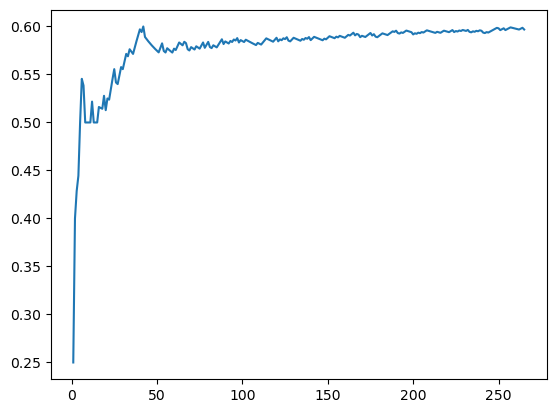

In [272]:
# Plot $b/a$ vs $b$ where $a$ is the generation (label length) where we first obtain an integer with $b$ zeros in the label.
plt.plot(X, Y)
plt.show()

<a id="a_b_graph_comments"></a>

# ^^^ Definitely not expecting the downturn in a/b at $\frac{b=41}{a=70}$

This is a lesson on just how far out into the generations one has to go in order to observe "consistent" "floor driven" behavior of $2^a/3^{|b|}$ behavior

Note: below we discover that a=70, b=42 is the ONLY time (for all cases checked so far a < 444) we have:
$$
b_{max}(a) = \lceil \frac{3a}{5} \rceil
$$
for a > 8, in all other cases (a < 444) we have $b_{max}(a) - \lceil \frac{3a}{5} \rceil \in [1,2,3,4]$

for a > 414 it looks like are trending even closer with $b_{max}(a) - \lceil \frac{3a}{5} \rceil \in [1,2]$

Could there be another regime change if we have another case where $b_{max}(a) = \lceil \frac{3a}{5} \rceil$ somwhere beyond a > 414?

In [ ]:
for i in range(len(A092893)):
    label = collatzPath(A092893[i])
    print((i+1, A092893[i], len(label), label[::-1]))

In [ ]:
for i in range(len(A092893)):
    print(f"{i+1} {A092893[i]}")


# ??? Is there any relationship between the A092893 values and the "illegal" modulus values?

The A092893 are related to the minimum value for a given $b$ and choose the minimum value for all related "$b$ zeros" minimum values in larger generations.

## The "illegal moduli":
- The powers of two (mod 3) cycle through the values $[2,1]$
    - "illegal": $[0]$
- The powers of two (mod 9) cycle through the values $[2,4,8, 7,5,1]$
    - "illegal": $[0, 3, 6]$
:


In [ ]:
min_3_2=1.0/4
max_3_2=1.0/4
for i in range(len(A092893)):
    b = i+1
    a = len(collatzPath(A092893[i]))
    r = b/a
    if r < min_3_2:
        min_3_2 = r
    if r > max_3_2:
        max_3_2 = r
print((min_3_2, max_3_2))

In [ ]:
# We can see an assymptopic approach to the last number's b/a ratio ...
#  -- this will always be true
#
for i in range(len(A092893)):
    b = i+1
    a = len(collatzPath(A092893[i]))
    r = b/a - (57/101)
    print((b, a, r))

In [ ]:
# It is interesting just how small the smallest numbers are in comparison to the prefix-length as the "b count" increases.
#
# Until we get to generation 52, the prefix accounts for all but one of the zeros
for i in range(len(A092893)):
    b = i+1
    a = len(collatzPath(A092893[i]))
    min_bits = math.ceil(math.log(A092893[i], 2))
    prefix_len = math.ceil(math.log(2*(3**b), 2))
    label = collatzPath(A092893[i])
    prefix = label[0:prefix_len]
    print((b, countZeros(prefix), a, min_bits, prefix_len, prefix))

In [ ]:
7,12,19,25,42,53

In [ ]:
def collectMinMaxInt_a_b_vals(a_max, b_max):
    rows = []
    if a_max < 4:
        return None
    def setMinMax(b_max, row, b, val, label):
        min_idx = 2*b
        max_idx = 2*b + 1
        if row[min_idx] is None or val < row[min_idx]:
            row[min_idx] = val
            row[2*b_max + min_idx] = label
        if row[max_idx] is None or val > row[max_idx]:
            row[max_idx] = val
            row[2*b_max + max_idx] = label
    #
    for a in range(4, a_max + 1, 1):
        row = [None]*(4*(b_max))        
        for prefix in generationLabels(a-3):
            label = prefix + "111"
            b = countZeros(prefix)
            if b < b_max:
                T = mrTupFromPath(label)
                val = mrTupValue(T)
                if val[1] == 1:
                        setMinMax(b_max, row, b, val[0], label)
        rows.append([a, b, a&1] + row)
    #
    return rows
#

In [ ]:
L = collectMinMaxInt_a_b_vals(20,17)
n_j = len(L)
n_i = len(L[0])
for i in range(n_i):
    row = []
    for j in range(n_j):
        row.append(L[j][i])
    print(row)

In [ ]:
# What do the prefixes for a=9 look like for the (mod 18) generations?
#  -- most definitely do not have 3 zeros each ...
for i in range(18):
    n = i + 2**9
    print( (i, computePrefixForModClass(9, n)) )

In [ ]:
tup = (2, 1, 5, 5, "0111")
for dummy in range(10):
    tup = next_smallest_generation_odd_value(tup)
    print(tup)

In [ ]:
for i in range(8):
    print((math.floor(2**(5*i+2)/(3**(i+1)))))

In [ ]:
for label in ['0111', '0110111', '011011110111', '01110111110110111', '0111111101111010110111', '011111111111111100010110111']:
    T = mrTupFromPath(label)
    print(mrTupToLaTex(T))

- $ \frac{2^{4}}{3^{1}} - (   \frac{2^{0}}{3^{1}} ) $
- $ \frac{2^{7}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{3}}{3^{2}} ) $
- $ \frac{2^{12}}{3^{3}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{3}}{3^{2}} + \frac{2^{8}}{3^{3}} ) $
- $ \frac{2^{17}}{3^{4}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{4}}{3^{2}} + \frac{2^{10}}{3^{3}} + \frac{2^{13}}{3^{4}} ) $
- $ \frac{2^{22}}{3^{5}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{8}}{3^{2}} + \frac{2^{13}}{3^{3}} + \frac{2^{15}}{3^{4}} + \frac{2^{18}}{3^{5}} ) $
- $ \frac{2^{27}}{3^{6}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{16}}{3^{2}} + \frac{2^{17}}{3^{3}} + \frac{2^{18}}{3^{4}} + \frac{2^{20}}{3^{5}} + \frac{2^{23}}{3^{6}} ) $

In [ ]:
for i in range(8):
    print((math.floor(2**(5*i+2)/(3**i))))

In [ ]:
next_smallest_generation_odd_values = [ 13, 141, 1477, 15445, 152917, 1627477, 17126741, 181753173]
for n in next_smallest_generation_odd_values:
    print(3*n + 1)

In [ ]:
next_smallest_generation_odd_values = [ 13, 141, 1477, 15445, 152917, 1627477, 17126741, 181753173]
for j in range(len(next_smallest_generation_odd_values)):
    n = next_smallest_generation_odd_values[j]
    i = j+1
    print((3*n + 1, math.floor(2**(5*i+2)/(3**i)) - 3*n + 1))

In [ ]:
for n in next_smallest_generation_odd_values:
    label = collatzPath(3*n + 1)
    print(label[::-1])

In [ ]:
# When we remove the first zero (3n+1 operation), 
for n in [3*k+1 for k in next_smallest_generation_odd_values]:
    print(factorint(n))

In [ ]:
# 5 53 277 181 7
# The miminal values grow fast, but
# for the minimal values, the factors of 2 following 3n+1
# grow even faster?

# The Per-Integer Affine Transform

This:
$$
V(N) = 2^a3^b - \sum_{(c,d) \in L}2^c3^d
$$

Directly leads to:
$$
3^{-b}V(N) + 3^{-b}\sum_{(c,d) \in L}2^c3^d = 2^a
$$

So we can always take a label in a given generation that is not for the $2^a$ value and find the affine transform to convert it to $2^a$

In [ ]:
def mrTupToGenerationAffineTup(T):
    """
    A slightly different form of the mixed-radix tuple with the $3^b$ value multiplied through
    """
    # Don't change the a=value
    a_b = T[0]
    # Change the b-value to be positive
    a_b_ = (a_b[0], -a_b[1])
    L = T[1]
    L_ = []
    for c_d in L:
        # Leave the c-values the same and add the new b-value to the old d-values
        c_d_ = (c_d[0], a_b_[1] + c_d[1])
        L_.append(c_d_)
    AT = (a_b_, L_)
    return AT
#

In [ ]:
mrTupToGenerationAffineTup(mrTupFromValue(5))

In [ ]:
def mrTupToGenerationAffineParams(T):
    AT = mrTupToGenerationAffineTup(T)
    # alpha is just the positive "b-value"
    alpha = 3**(AT[0][1])
    beta = 0
    for c_d in AT[1]:
        beta += (2**c_d[0])*(3**c_d[1])
    return (alpha, beta)
#

In [ ]:
mrTupToGenerationAffineParams(mrTupFromValue(5))

In [ ]:
# 27 is the smallest integer to have 41 label-zeros (A092893). 
# generation 70 is the first time we have 41 label-zeros.
print(mrTupFromValue(27)[0])
print(collatzPath(27))

In [ ]:
mrTupToGenerationAffineParams(mrTupFromValue(27))

In [ ]:
195820718533800070543 % (3**(41))

In [ ]:
print(36472996377170786403 % (2**70))
print(27 % (2**70))
print((27 * 36472996377170786403) % (2**70))
print(195820718533800070543 % (2**70))
print((27 * 36472996377170786403 + 195820718533800070543) % (2**70))

In [ ]:
def generationAffineTupFromPath(label):
    """ Create an  given a path (label)
    """
    mr_tup = N_i
    for bit in label:
        if bit == "1":
            mr_tup = F_1(mr_tup)
        else:
            mr_tup = F_0(mr_tup)
    return mrTupToGenerationAffineTup(mr_tup)
#
def generationAffineParamsFromPath(label):
    AT = generationAffineTupFromPath(label)
    A = 3**(AT[0][1])
    B = 0
    for c_d in AT[1]:
        B += (2**c_d[0])*(3**c_d[1])
    return (A, B)
#

In [ ]:
generationAffineParamsFromPath("0111")

In [ ]:
def generationAffineParamsFromPath(label):
    """
    Generate the Affine Parameters for Ax + B that converts any label in the lattice to 
    the power of 2 of its generation.

    e.g.  5 -> "0111" -> A=3,B=1 -> 3*5 + 1 -> 2**4
    """
    a, b = len(label), countZeros(label)
    A = 3**(b)
    d = b - 1
    B = 0
    for c in range(a):
        if label[c] == "0":
            B += (2**c)*(3**d) 
            d -= 1
    return A, B
#

In [ ]:
generationAffineParamsFromPath("0111")

In [ ]:
generationAffineParamsFromPath(collatzPath(27))

# Find ceiling solution counting forms

In [273]:
mrTupValue(mrTupFromPath("00111"))

(3, 1)

In [274]:
MIN_A_FOR_B = {1:4, 2:5}
for i in range(len(A092893)):
    b = i+1
    a = len(collatzPath(A092893[i]))
    MIN_A_FOR_B[b] = a
MIN_A_FOR_B

{1: 4,
 2: 5,
 3: 7,
 4: 9,
 5: 10,
 6: 11,
 7: 13,
 8: 16,
 9: 18,
 10: 20,
 11: 22,
 12: 23,
 13: 26,
 14: 28,
 15: 30,
 16: 31,
 17: 33,
 18: 35,
 19: 36,
 20: 39,
 21: 40,
 22: 42,
 23: 43,
 24: 44,
 25: 45,
 26: 48,
 27: 50,
 28: 51,
 29: 52,
 30: 54,
 31: 55,
 32: 56,
 33: 58,
 34: 59,
 35: 61,
 36: 63,
 37: 64,
 38: 65,
 39: 66,
 40: 67,
 41: 69,
 42: 70,
 43: 73,
 44: 75,
 45: 77,
 46: 79,
 47: 81,
 48: 83,
 49: 85,
 50: 87,
 51: 89,
 52: 90,
 53: 91,
 54: 94,
 55: 96,
 56: 97,
 57: 99,
 58: 101,
 59: 103,
 60: 104,
 61: 106,
 62: 107,
 63: 108,
 64: 110,
 65: 112,
 66: 113,
 67: 115,
 68: 118,
 69: 120,
 70: 121,
 71: 123,
 72: 125,
 73: 126,
 74: 128,
 75: 130,
 76: 131,
 77: 132,
 78: 135,
 79: 136,
 80: 137,
 81: 140,
 82: 142,
 83: 143,
 84: 145,
 85: 147,
 86: 148,
 87: 149,
 88: 150,
 89: 153,
 90: 154,
 91: 156,
 92: 158,
 93: 159,
 94: 161,
 95: 162,
 96: 164,
 97: 165,
 98: 168,
 99: 169,
 100: 171,
 101: 173,
 102: 174,
 103: 176,
 104: 178,
 105: 180,
 106: 182,
 10

In [294]:
x_for_query = []
y_for_query = []
deltas_for_query = []
for b in MIN_A_FOR_B:
    a = MIN_A_FOR_B[b]
    if b > 100:
        x_for_query.append(a)
        y_for_query.append(b)
        deltas_for_query.append(math.ceil(3 * a / 5) - b)


In [295]:
deltas_for_query

[3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 2,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2]

In [292]:
delta_count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
for b in MIN_A_FOR_B:
    a = MIN_A_FOR_B[b]
    if  math.ceil(3 * a / 5) < 6:
        print(f"upper rule violation:  a={a}, b={b}")
    else:
        delta = math.ceil(3 * a / 5) - b
        delta_count[ delta ] += 1
        if delta == 0:
            print(f"upper rule equivalence:  a={a}, b={b}")


upper rule violation:  a=4, b=1
upper rule violation:  a=5, b=2
upper rule violation:  a=7, b=3
upper rule equivalence:  a=70, b=42


In [290]:
delta_count

{0: 1, 1: 20, 2: 73, 3: 138, 4: 30, 5: 0, 6: 0}

## $ \lceil \frac{3a}{5} \rceil$ is a very good upper bound estimator for a > 8

It is at most 4 larger than target, typical three larger, rarely exact.

See the [related comments](#a_b_graph_comments) below the $b/a$ versus $b$ chart above

In [281]:
3 * math.ceil(174 / 5), 3 * math.ceil(444 / 5)

(105, 267)

In [307]:
def max_b_for_a(a):
    if a < 4:
        return 0
    elif a <= 8:
        for b in MIN_A_FOR_B:
            a_ = MIN_A_FOR_B[b]
            if a_ > a:
                return b-1
    else:
        upper = math.ceil(3*a / 5)
        # Work our way down 
        for b in range(upper, upper-4, -1):
            a_ = MIN_A_FOR_B[b]
            if a_ == a:
                return b
            elif a_ < a:
                return b

    print(f"Error: did not find max_b for a={a}")
#
    
    

We know:
$$
b = 0 \mapsto \#_0(a) = 1
$$
$$
b = 1 \mapsto \#_1(a) = \lceil\frac{a-(b+2)}{2}\rceil
$$
$$
b = 2, a \text{ odd } \mapsto \#_{2,odd}(a) = \lceil\frac{(a-(b+2))^2}{2^2 \cdot 3}\rceil
$$
$$
b = 2, a \text{ even } \mapsto \#_{2,even}(a) = \lceil\frac{(\frac{a-4}{2})^2 + \frac{a-4}{2}}{3}\rceil
$$

These solution counts come from the original reverse Collatz form ... but the "count of 3n+1's" which drive this is the same for the lattice ... right? 

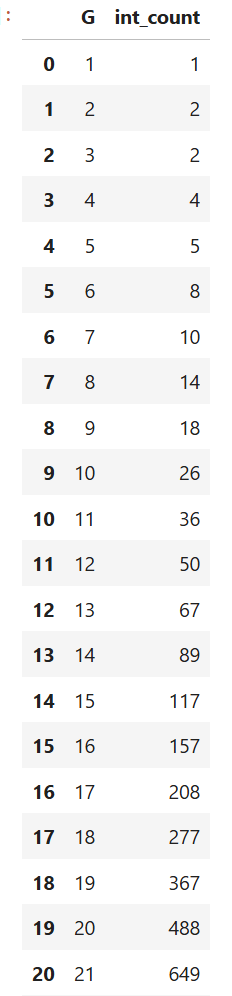

In [321]:
def solutionCounter_0(a):
    return 1
#
def solutionCount_1(a):
    """
    Solution count for b==1 for a given a.  Does not include degenerate values.
    """
    if a < 3:
        return 0
    return math.ceil((a-3)/2)
#
def makeSolutionCounter(a, b):
    t = (a - (b+2))
    if a & 1 == 1:
        def solutionCounterOdd(a):
            solns = math.ceil(t**b /( (2**b) * (3**(b-1)) ) )
            print((a, b, "->", solns))
            return solns
        return solutionCounterOdd
    else:
        def solutionCounterEven(a):
            solns = math.ceil((t**b + 2*(t**(b-1)) )/( (2**b) * (3**(b-1)) ) )
            print((a, b, "->", solns))
            return solns
        return solutionCounterEven
#
def getSolutionCounters(a):
    functions = [solutionCounter_0]    
    max_b = max_b_for_a(a)

    if max_b == 0:
        return functions
    else:
        functions.append(solutionCount_1)
        if max_b > 1:
            for b in range(2, max_b+1, 1):
                functions.append(makeSolutionCounter(a, b))
    return functions
#
def getSolutionCount(a):
    accum = 0
    for count_func in getSolutionCounters(a):
        accum += count_func(a)
    return accum
#

In [335]:
# Does not include degenerate labels ...
solutionCount_1(8)

3

In [336]:
# Does not include degenerate labels ...
solutionCount_1(10)

4

In [337]:
solution_counts = [1]
for a in range(1, 20, 1):
    solution_counts.append(getSolutionCount(a))

even_accum = 0
odd_accum = 0

for i in range(len(solution_counts)):
    if i & 1 == 0:
        even_accum += solution_counts[i]
        print(even_accum)
    else:
        odd_accum += solution_counts[i]
        print(odd_accum)
        

(5, 2, '->', 1)
(6, 2, '->', 1)
(7, 2, '->', 1)
(7, 3, '->', 1)
(8, 2, '->', 2)
(8, 3, '->', 1)
(9, 2, '->', 3)
(9, 3, '->', 1)
(9, 4, '->', 1)
(10, 2, '->', 4)
(10, 3, '->', 3)
(10, 4, '->', 1)
(10, 5, '->', 1)
(11, 2, '->', 5)
(11, 3, '->', 3)
(11, 4, '->', 2)
(11, 5, '->', 1)
(11, 6, '->', 1)
(12, 2, '->', 7)
(12, 3, '->', 7)
(12, 4, '->', 4)
(12, 5, '->', 2)
(12, 6, '->', 1)
(13, 2, '->', 7)
(13, 3, '->', 8)
(13, 4, '->', 6)
(13, 5, '->', 3)
(13, 6, '->', 2)
(13, 7, '->', 1)
(14, 2, '->', 10)
(14, 3, '->', 13)
(14, 4, '->', 12)
(14, 5, '->', 9)
(14, 6, '->', 4)
(14, 7, '->', 2)
(15, 2, '->', 11)
(15, 3, '->', 14)
(15, 4, '->', 16)
(15, 5, '->', 13)
(15, 6, '->', 8)
(15, 7, '->', 3)
(16, 2, '->', 14)
(16, 3, '->', 22)
(16, 4, '->', 28)
(16, 5, '->', 28)
(16, 6, '->', 22)
(16, 7, '->', 12)
(16, 8, '->', 4)
(17, 2, '->', 15)
(17, 3, '->', 24)
(17, 4, '->', 34)
(17, 5, '->', 39)
(17, 6, '->', 35)
(17, 7, '->', 23)
(17, 8, '->', 11)
(18, 2, '->', 19)
(18, 3, '->', 36)
(18, 4, '->', 56)


In [323]:
solution_counts

[1, 1, 1, 1, 2, 3, 4, 5, 7, 9, 14, 17, 27, 33, 57, 72, 138, 189, 389, 569]

In [324]:
solution_counts[10], solution_counts[11]

(14, 17)

In [325]:
math.ceil(3*10 / 5)

6

In [326]:
MIN_A_FOR_B[6]

11

In [327]:
MIN_A_FOR_B[5]

10

In [332]:
intsBy_a_b = {}

def collectInt(a, b, label):
    if (a, b, False) not in intsBy_a_b:
        intsBy_a_b[(a, b, False)] = 0
        intsBy_a_b[(a, b, True)] = 0
    #
    intsBy_a_b[(a, b, False)] += 1
    if label == "1" or label == "11" or label[-3:] == "111":
            intsBy_a_b[(a, b, True)] += 1
#
for a in range(3, 21, 1):
    for b in range(1, 4, 1):
        if b >= a:
            continue
        for label in generationLabelChoices(a, b):
            T = mrTupFromPath(label)
            val = mrTupValue(T)
            if val[1] == 1:
                collectInt(a, b, label)
#
intsBy_a_b

{(3, 1, False): 1,
 (3, 1, True): 0,
 (4, 1, False): 2,
 (4, 1, True): 1,
 (4, 2, False): 1,
 (4, 2, True): 0,
 (5, 1, False): 2,
 (5, 1, True): 1,
 (5, 2, False): 2,
 (5, 2, True): 1,
 (6, 1, False): 3,
 (6, 1, True): 2,
 (6, 2, False): 3,
 (6, 2, True): 1,
 (6, 3, False): 1,
 (6, 3, True): 0,
 (7, 1, False): 3,
 (7, 1, True): 2,
 (7, 2, False): 4,
 (7, 2, True): 2,
 (7, 3, False): 2,
 (7, 3, True): 0,
 (8, 1, False): 4,
 (8, 1, True): 3,
 (8, 2, False): 5,
 (8, 2, True): 2,
 (8, 3, False): 3,
 (8, 3, True): 0,
 (9, 1, False): 4,
 (9, 1, True): 3,
 (9, 2, False): 6,
 (9, 2, True): 3,
 (9, 3, False): 5,
 (9, 3, True): 1,
 (10, 1, False): 5,
 (10, 1, True): 4,
 (10, 2, False): 8,
 (10, 2, True): 4,
 (10, 3, False): 7,
 (10, 3, True): 2,
 (11, 1, False): 5,
 (11, 1, True): 4,
 (11, 2, False): 10,
 (11, 2, True): 6,
 (11, 3, False): 10,
 (11, 3, True): 4,
 (12, 1, False): 6,
 (12, 1, True): 5,
 (12, 2, False): 12,
 (12, 2, True): 7,
 (12, 3, False): 14,
 (12, 3, True): 6,
 (13, 1, False):

In [338]:
solutionCount_1(20)

9

In [339]:
makeSolutionCounter(20, 2)(20)

(20, 2, '->', 24)


24

In [340]:
makeSolutionCounter(20, 3)(20)

(20, 3, '->', 54)


54

In [341]:
factorint(116)

{2: 2, 29: 1}

In [345]:
for a in range(41, 50, 2):
    b = 3
    for label in generationLabelChoices(a, b):
        T = mrTupFromPath(label)
        val = mrTupValue(T)
        if val[1] == 1:
            collectInt(a, b, label)
#


(9, 1)
(11, 4)
(13, 8)
(15, 13)
(17, 22)
(19, 33)
(21, 144)
(23, 201)
(25, 270)
(27, 354)
(29, 456)
(31, 573)
(33, 705)
(35, 861)
(37, 1035)
(39, 1233)
(41, 485)
(43, 567)
(45, 658)
(47, 759)
(49, 869)


In [353]:
for a in range(9, 39, 2):
    key = (a, 3, True)
    count = intsBy_a_b[key]
    i = a-9
    count_ = math.ceil((i**3)/16*27)
    print((a, count, count_))

(9, 1, 0)
(11, 4, 14)
(13, 8, 108)
(15, 13, 365)
(17, 22, 864)
(19, 33, 1688)
(21, 144, 2916)
(23, 201, 4631)
(25, 270, 6912)
(27, 354, 9842)
(29, 456, 13500)
(31, 573, 17969)
(33, 705, 23328)
(35, 861, 29660)
(37, 1035, 37044)


In [354]:
L = []
for a in range(9, 39, 2):
    key = (a, 3, True)
    count = intsBy_a_b[key]
    L.append(count)
L

[1, 4, 8, 13, 22, 33, 144, 201, 270, 354, 456, 573, 705, 861, 1035]